In [1]:
import torch
 
torch.manual_seed(0)    #A
 
observations = 2048
 
train_data = torch.zeros((observations, 2))    #B
 
train_data[:,0]=50*torch.rand(observations)    #C
 
train_data[:,1]=1.08**train_data[:,0]    #D

In [2]:
train_data.shape

torch.Size([2048, 2])

In [3]:
train_data

tensor([[24.8128,  6.7505],
        [38.4111, 19.2240],
        [ 4.4239,  1.4056],
        ...,
        [29.3746,  9.5898],
        [41.3159, 24.0399],
        [14.5458,  3.0632]])

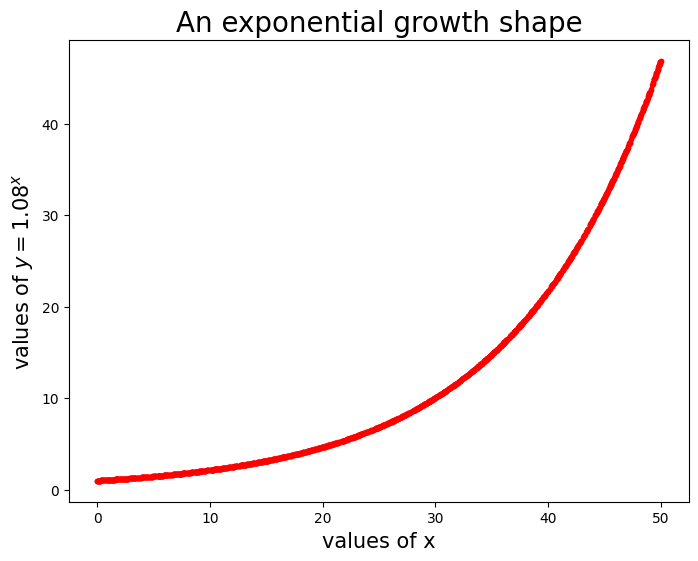

In [4]:
import matplotlib.pyplot as plt
 
fig=plt.figure(dpi=100,figsize=(8,6))
plt.plot(train_data[:,0],train_data[:,1],".",c="r")    #A
plt.xlabel("values of x",fontsize=15)
plt.ylabel("values of $y=1.08^x$",fontsize=15)    #B
plt.title("An exponential growth shape",fontsize=20)    #C
plt.show()

In [5]:
from torch.utils.data import DataLoader

batch_size=128
train_loader=DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True)

In [6]:
batch0=next(iter(train_loader))
print(batch0)

tensor([[41.9333, 25.2099],
        [ 8.0561,  1.8589],
        [22.2487,  5.5416],
        [49.9585, 46.7522],
        [ 8.7647,  1.9631],
        [ 3.0979,  1.2692],
        [26.0517,  7.4259],
        [38.2393, 18.9716],
        [37.1300, 17.4191],
        [45.0543, 32.0541],
        [ 8.7989,  1.9683],
        [20.4796,  4.8362],
        [46.7506, 36.5243],
        [21.8242,  5.3635],
        [11.2329,  2.3738],
        [40.3307, 22.2845],
        [47.0477, 37.3691],
        [47.6369, 39.1026],
        [16.2331,  3.4880],
        [11.7535,  2.4709],
        [12.8855,  2.6958],
        [20.6749,  4.9095],
        [ 4.6602,  1.4314],
        [26.3385,  7.5916],
        [31.7039, 11.4727],
        [45.5565, 33.3172],
        [41.3369, 24.0788],
        [26.8584,  7.9015],
        [14.9879,  3.1692],
        [33.7039, 13.3817],
        [47.7350, 39.3988],
        [31.7714, 11.5324],
        [ 7.4853,  1.7790],
        [14.5973,  3.0754],
        [31.4056, 11.2122],
        [35.8166, 15

In [7]:
import torch.nn as nn
 
device="cuda" if torch.cuda.is_available() else "cpu"    #A
 
D=nn.Sequential(
    nn.Linear(2,256),    #B
    nn.ReLU(),
    nn.Dropout(0.3),    #C
    nn.Linear(256,128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64,1),    #D
    nn.Sigmoid()).to(device)


In [8]:
G=nn.Sequential(
    nn.Linear(2,16),    #A
    nn.ReLU(),
    nn.Linear(16,32),
    nn.ReLU(),
    nn.Linear(32,2)).to(device)    #B

In [9]:
loss_fn=nn.BCELoss()
lr=0.0005
optimD=torch.optim.Adam(D.parameters(),lr=lr)
optimG=torch.optim.Adam(G.parameters(),lr=lr)

In [10]:
mse=nn.MSELoss()    #A
 
def performance(fake_samples):
    real=1.08**fake_samples[:,0]    #B
    mseloss=mse(fake_samples[:,1],real)   #C
    return mseloss


In [11]:
class EarlyStop:
    def __init__(self, patience=1000):    #A
        self.patience = patience
        self.steps = 0
        self.min_gdif = float('inf')
    def stop(self, gdif):    #B
        if gdif < self.min_gdif:    #C
            self.min_gdif = gdif
            self.steps = 0
        elif gdif >= self.min_gdif:
            self.steps += 1
        if self.steps >= self.patience:    #D
            return True
        else:
            return False
 
stopper=EarlyStop()


In [12]:

real_labels=torch.ones((batch_size,1))
real_labels=real_labels.to(device)
 
fake_labels=torch.zeros((batch_size,1))
fake_labels=fake_labels.to(device)

In [13]:
def train_D_on_real(real_samples):
    real_samples=real_samples.to(device)
    optimD.zero_grad()
    out_D=D(real_samples)    #A
    loss_D=loss_fn(out_D,real_labels)    #B
    loss_D.backward()
    optimD.step()    #C
    return loss_D


In [14]:
def train_D_on_fake():        
    noise=torch.randn((batch_size,2))
    noise=noise.to(device)
    fake_samples=G(noise)     #A
    optimD.zero_grad()
    out_D=D(fake_samples)    #B
    loss_D=loss_fn(out_D,fake_labels)    #C
    loss_D.backward()
    optimD.step()    #D
    return loss_D


In [15]:
def train_G(): 
    noise=torch.randn((batch_size,2))
    noise=noise.to(device)
    optimG.zero_grad()
    fake_samples=G(noise)    #A
    out_G=D(fake_samples)    #B
    loss_G=loss_fn(out_G,real_labels)    #C
    loss_G.backward()
    optimG.step()     #D
    return loss_G, fake_samples 


In [16]:
import os
os.makedirs("files", exist_ok=True)    #A
 
def test_epoch(epoch,gloss,dloss,n,fake_samples):
    if epoch==0 or (epoch+1)%25==0:
        g=gloss.item()/n
        d=dloss.item()/n
        print(f"at epoch {epoch+1}, G loss: {g}, D loss {d}")    #B
        fake=fake_samples.detach().cpu().numpy()
        plt.figure(dpi=200)
        plt.plot(fake[:,0],fake[:,1],"*",c="g",
            label="generated samples")    #C
        plt.plot(train_data[:,0],train_data[:,1],".",c="r",
            alpha=0.1,label="real samples")    #D
        plt.title(f"epoch {epoch+1}")
        plt.xlim(0,50)
        plt.ylim(0,50)
        plt.legend()
        plt.savefig(f"files/p{epoch+1}.png")
        plt.show()

at epoch 1, G loss: 0.7837384541829427, D loss 0.8468931198120118


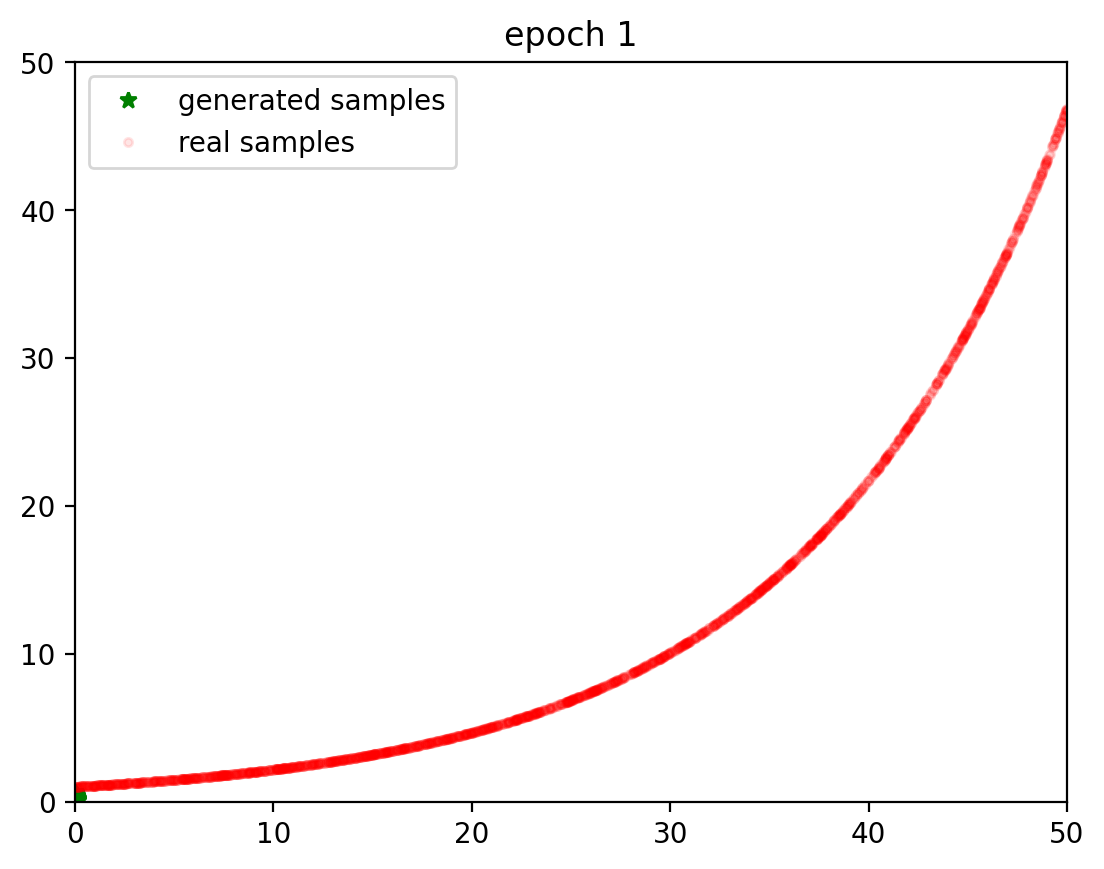

at epoch 25, G loss: 2.5625010172526044, D loss 0.4211556434631348


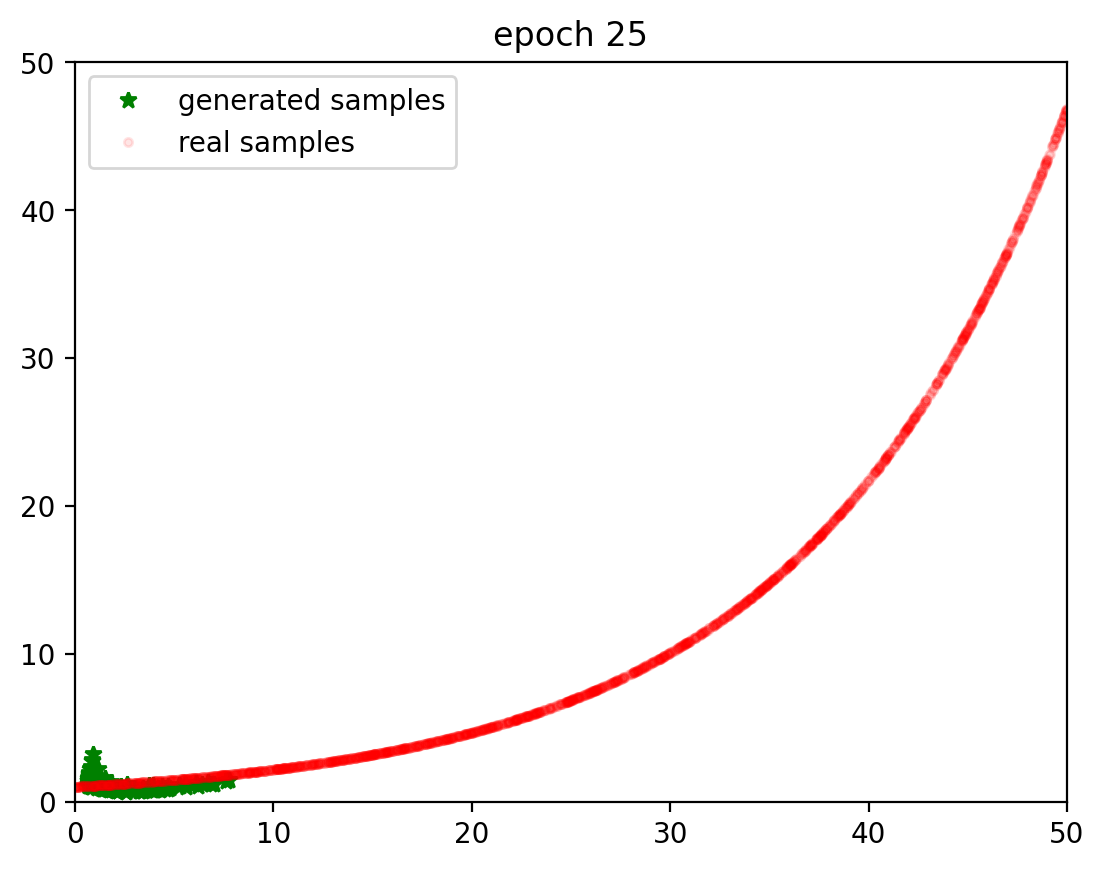

at epoch 50, G loss: 1.543838119506836, D loss 0.8760923385620117


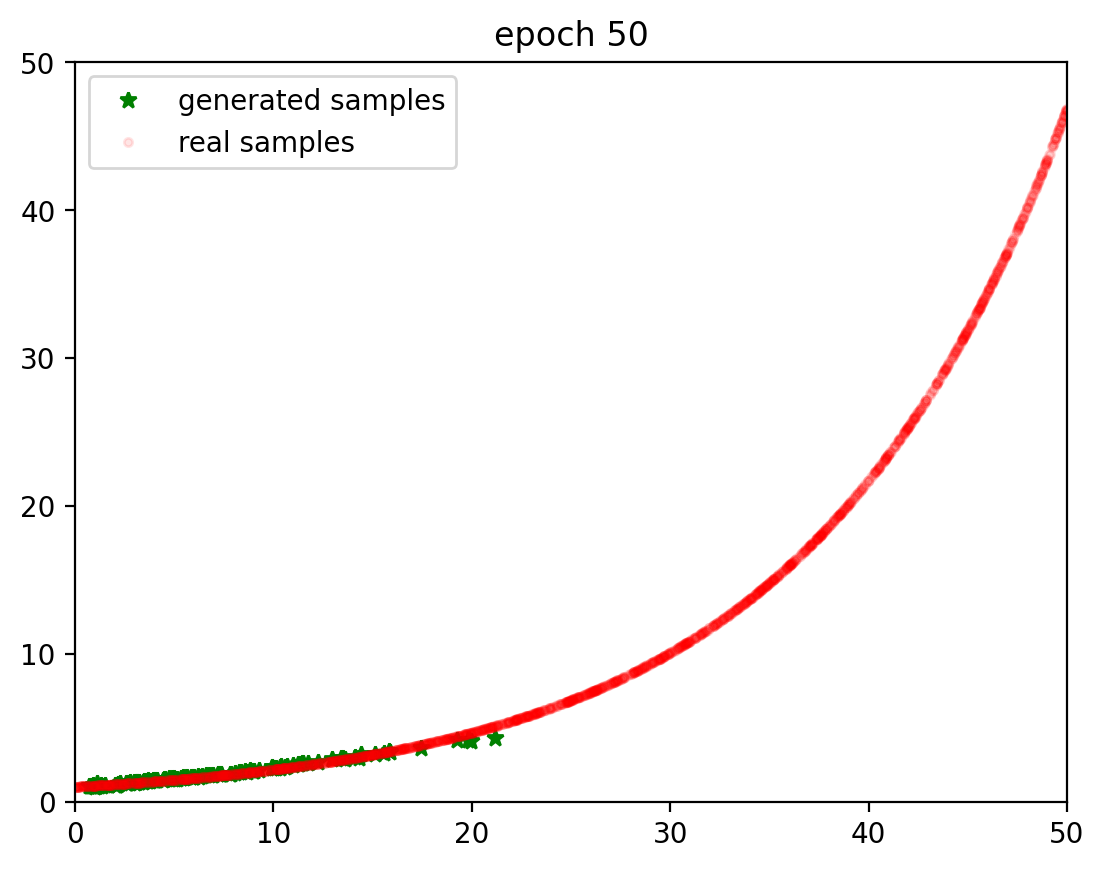

at epoch 75, G loss: 1.1528673807779948, D loss 1.068607711791992


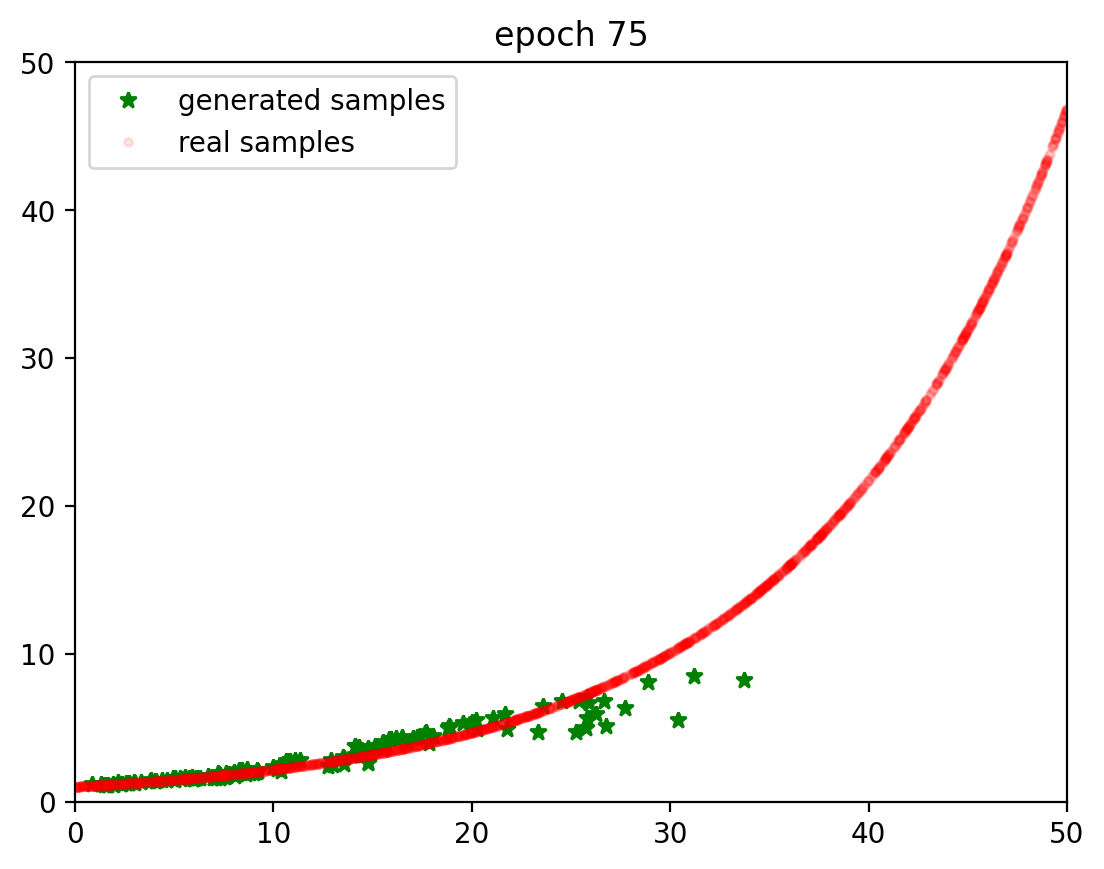

at epoch 100, G loss: 1.0089480717976889, D loss 1.1803075154622396


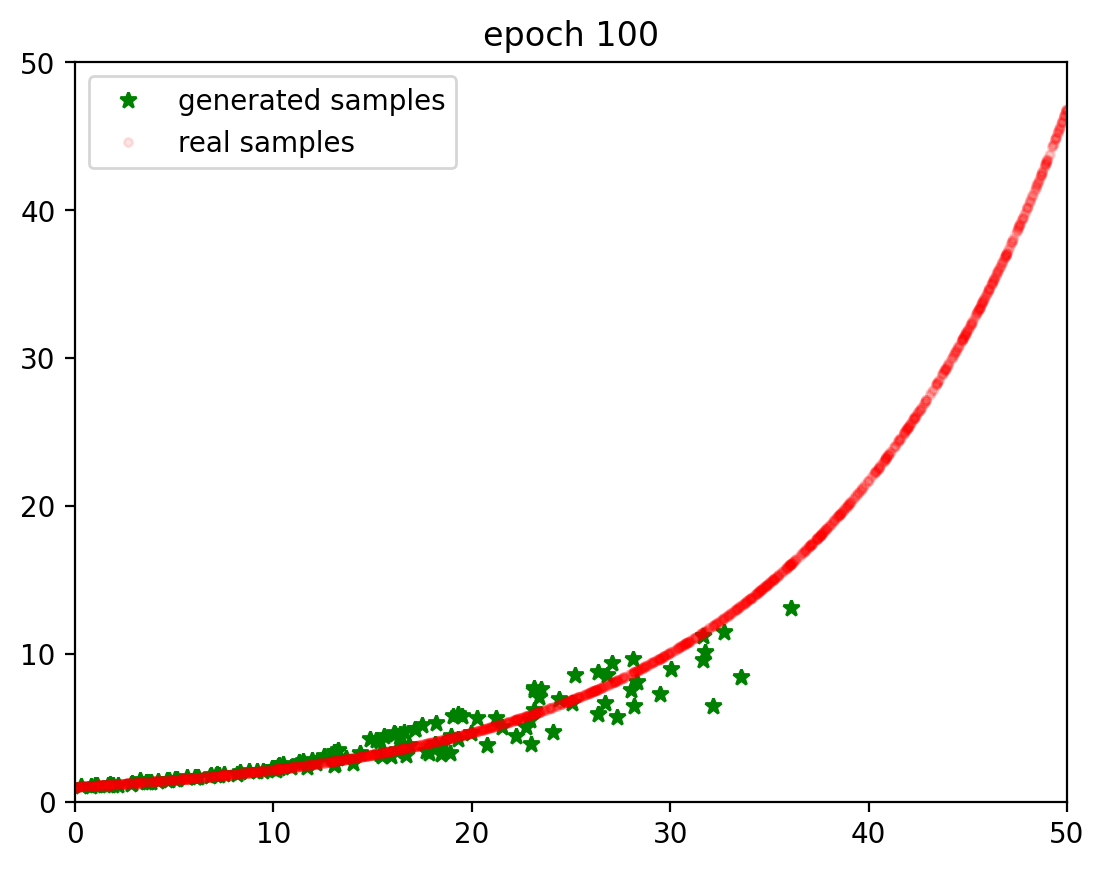

at epoch 125, G loss: 0.906339963277181, D loss 1.293405787150065


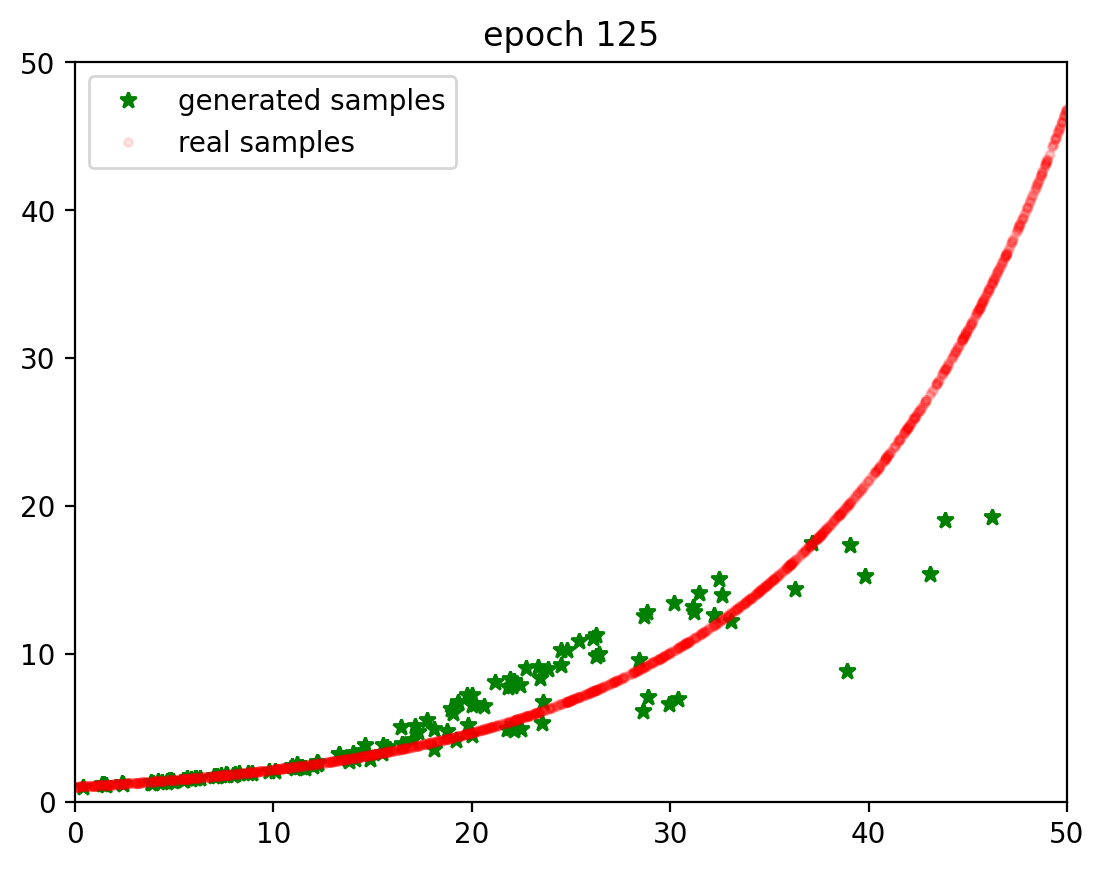

at epoch 150, G loss: 0.8447266896565755, D loss 1.3828084309895834


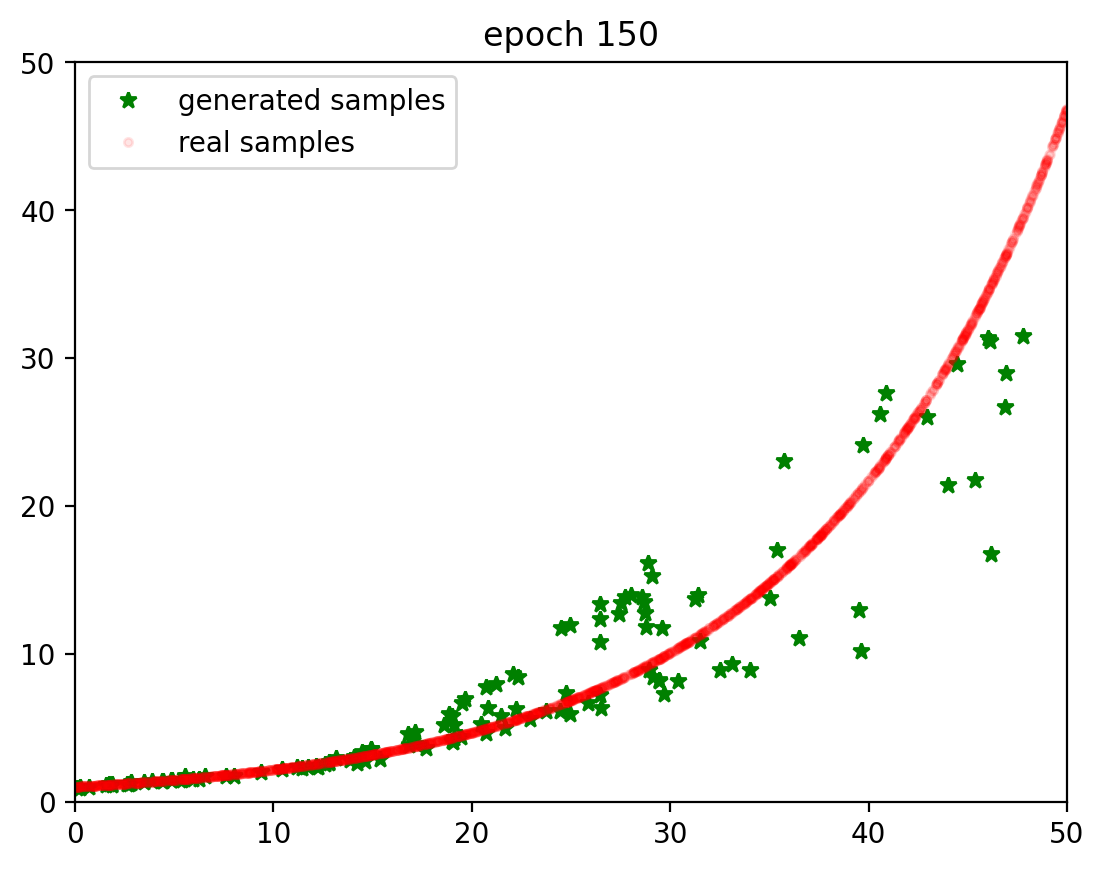

at epoch 175, G loss: 0.7887440999348958, D loss 1.4644087473551433


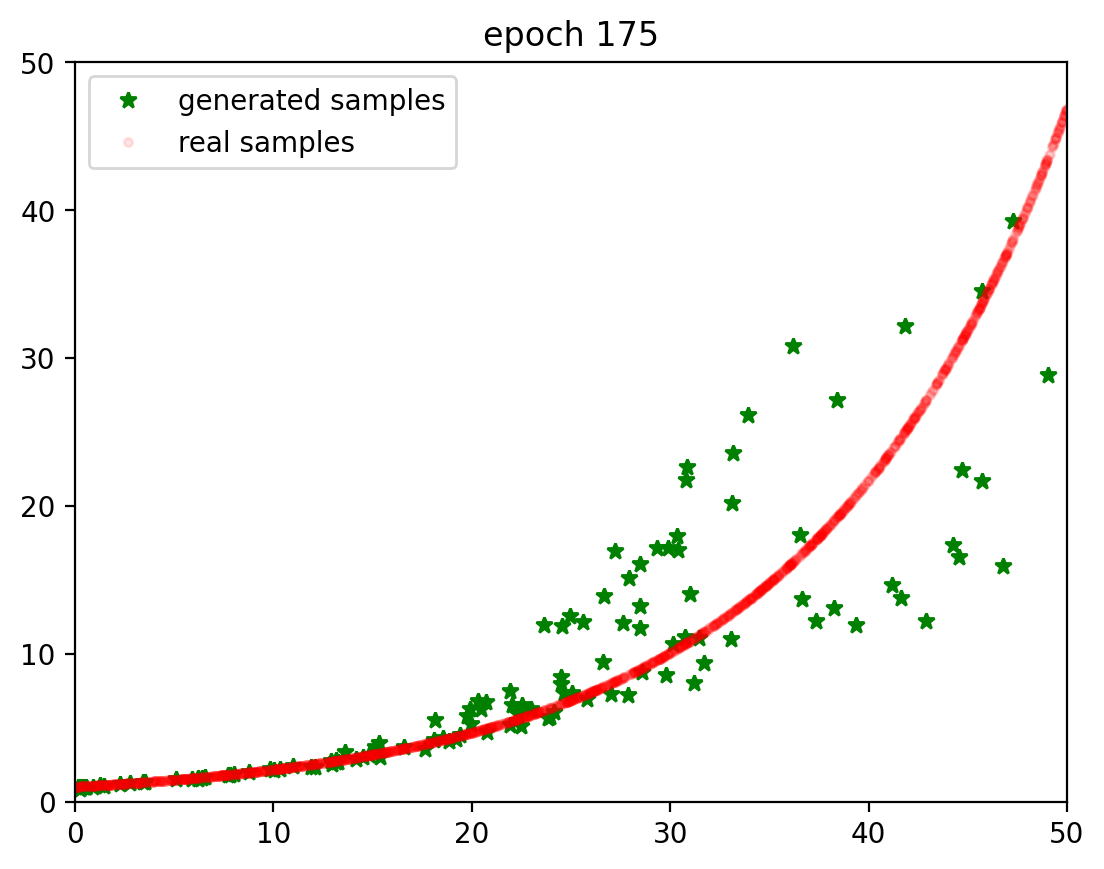

at epoch 200, G loss: 0.7848538716634115, D loss 1.4711158752441407


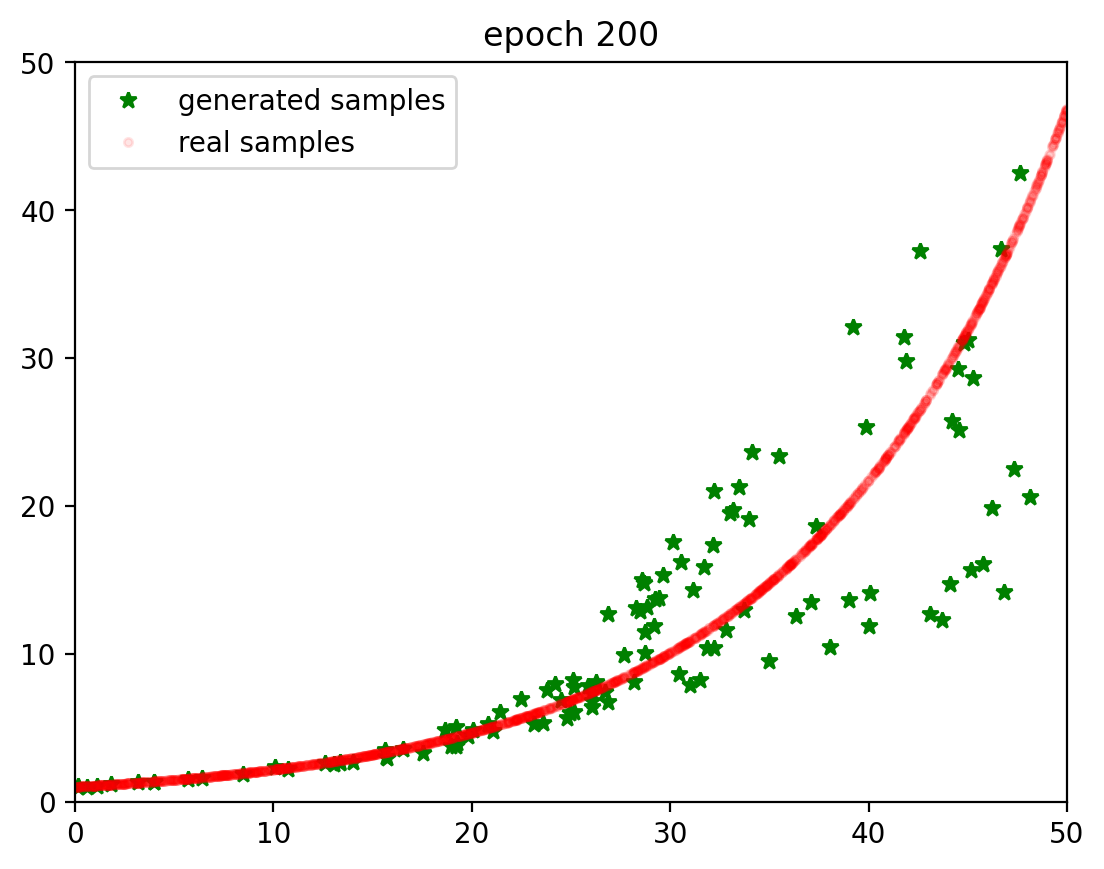

at epoch 225, G loss: 0.7776358922322592, D loss 1.4770800272623699


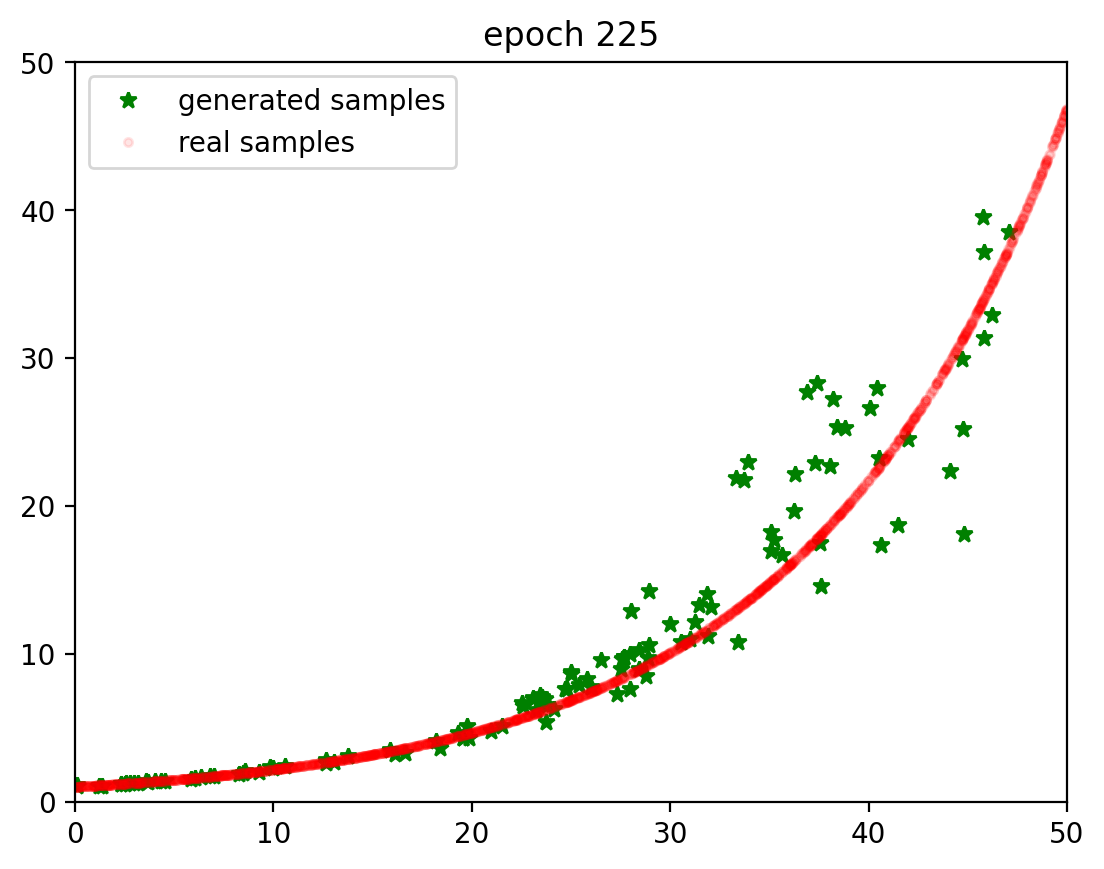

at epoch 250, G loss: 0.7757694880167644, D loss 1.4801331837972005


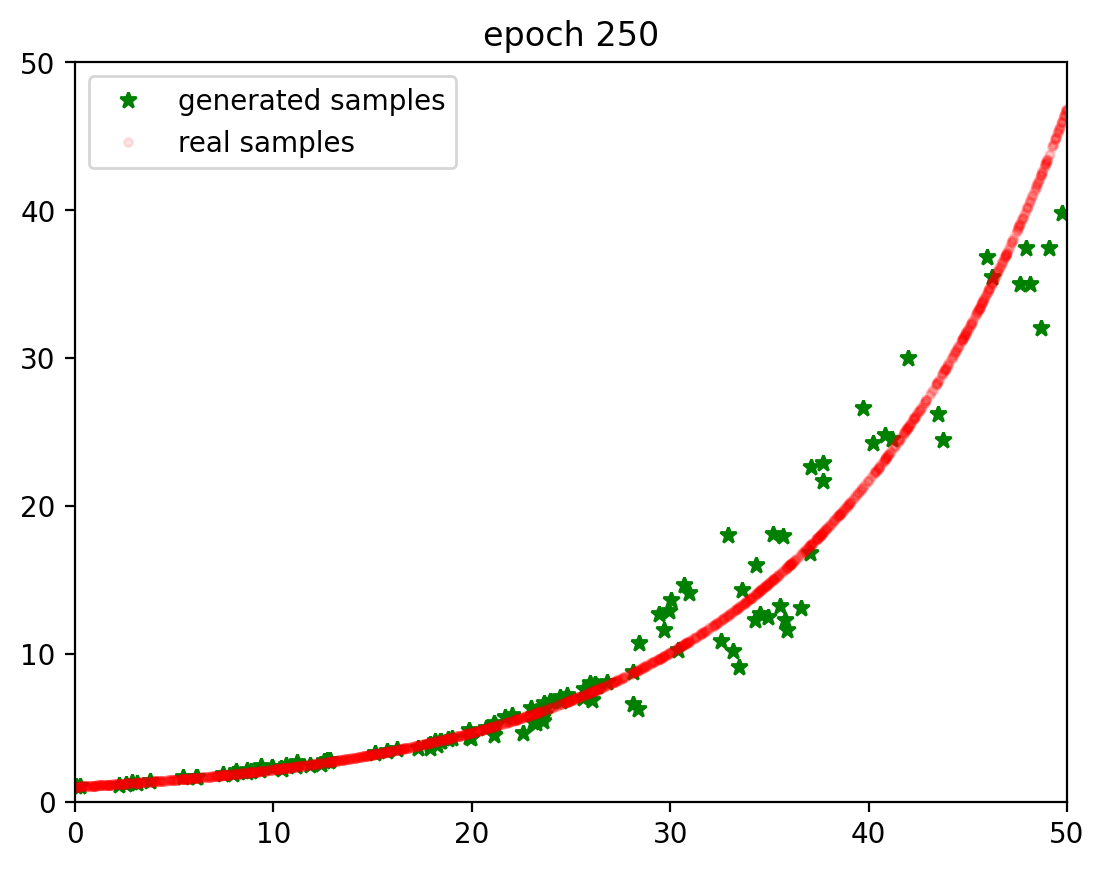

at epoch 275, G loss: 0.7605068206787109, D loss 1.481179936726888


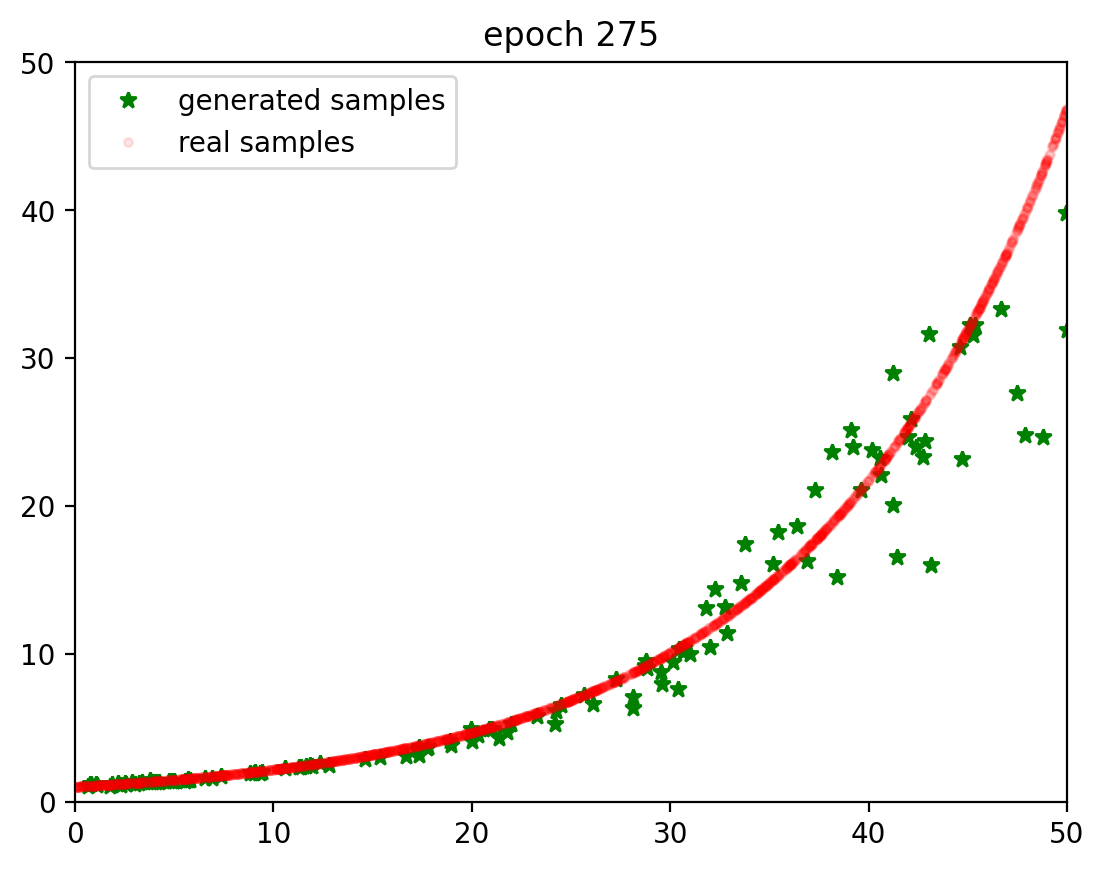

at epoch 300, G loss: 0.7660559336344401, D loss 1.4762279510498046


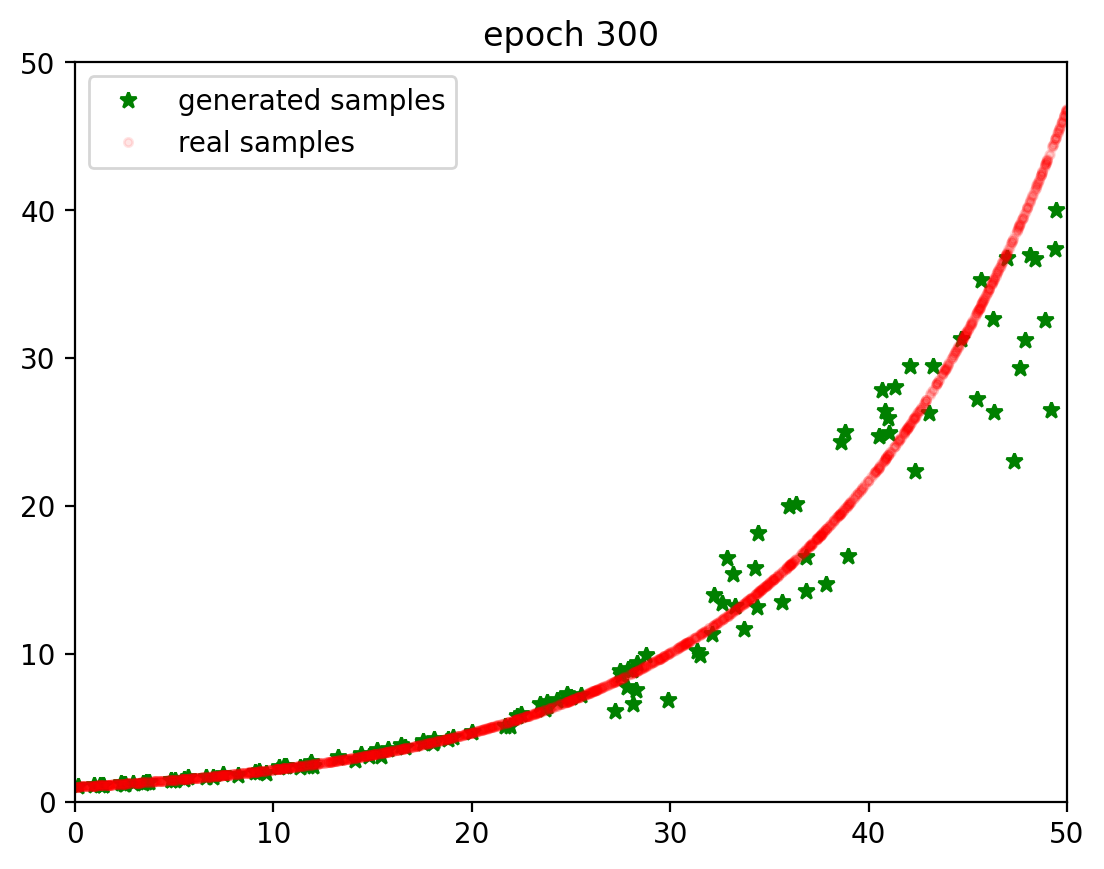

at epoch 325, G loss: 0.7621745427449544, D loss 1.4776261647542317


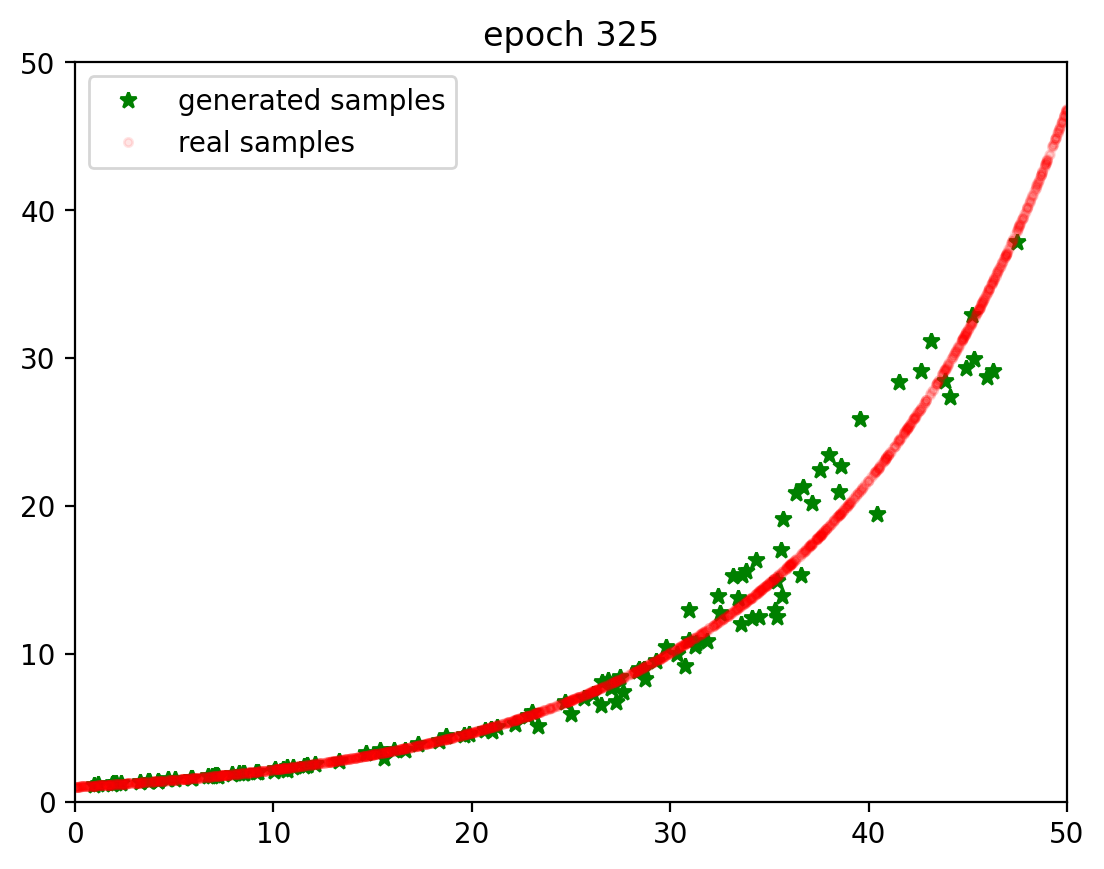

at epoch 350, G loss: 0.7530064900716146, D loss 1.4790004730224608


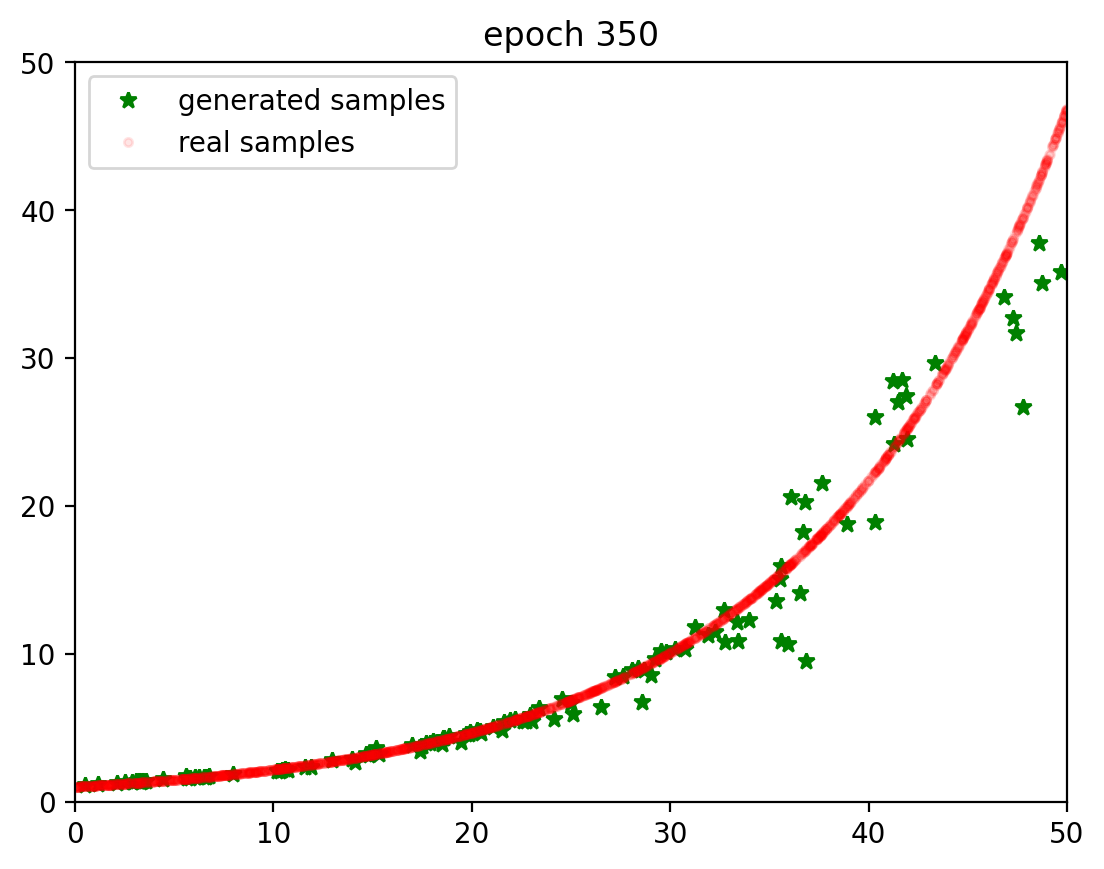

at epoch 375, G loss: 0.7516302744547526, D loss 1.4786186218261719


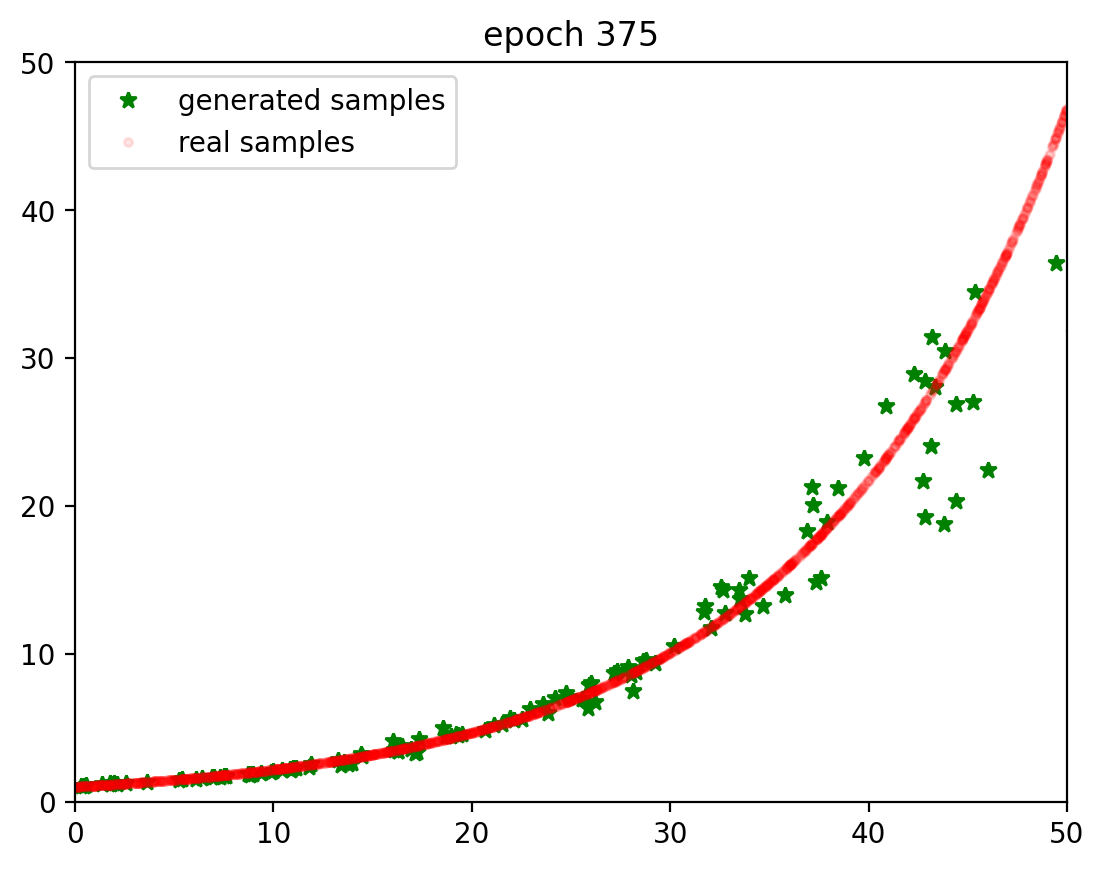

at epoch 400, G loss: 0.7631792068481446, D loss 1.4815086364746093


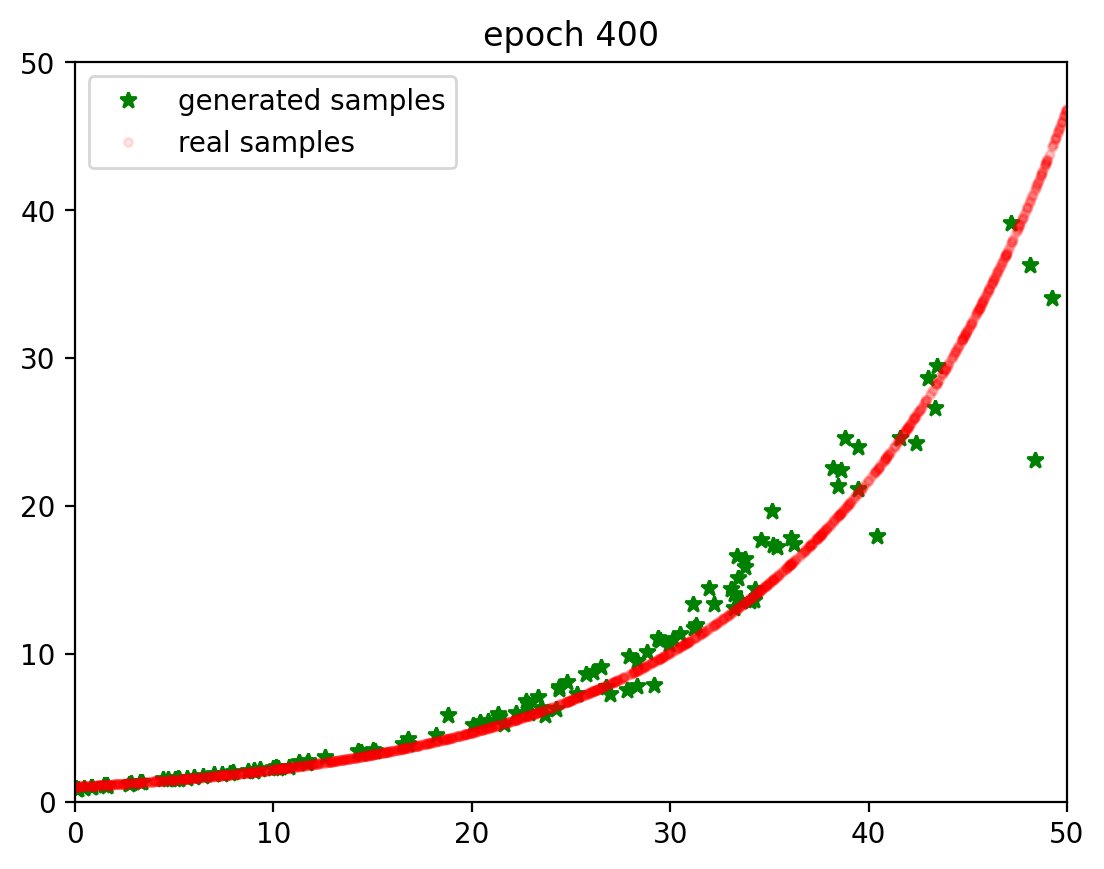

at epoch 425, G loss: 0.7541536331176758, D loss 1.4793670654296875


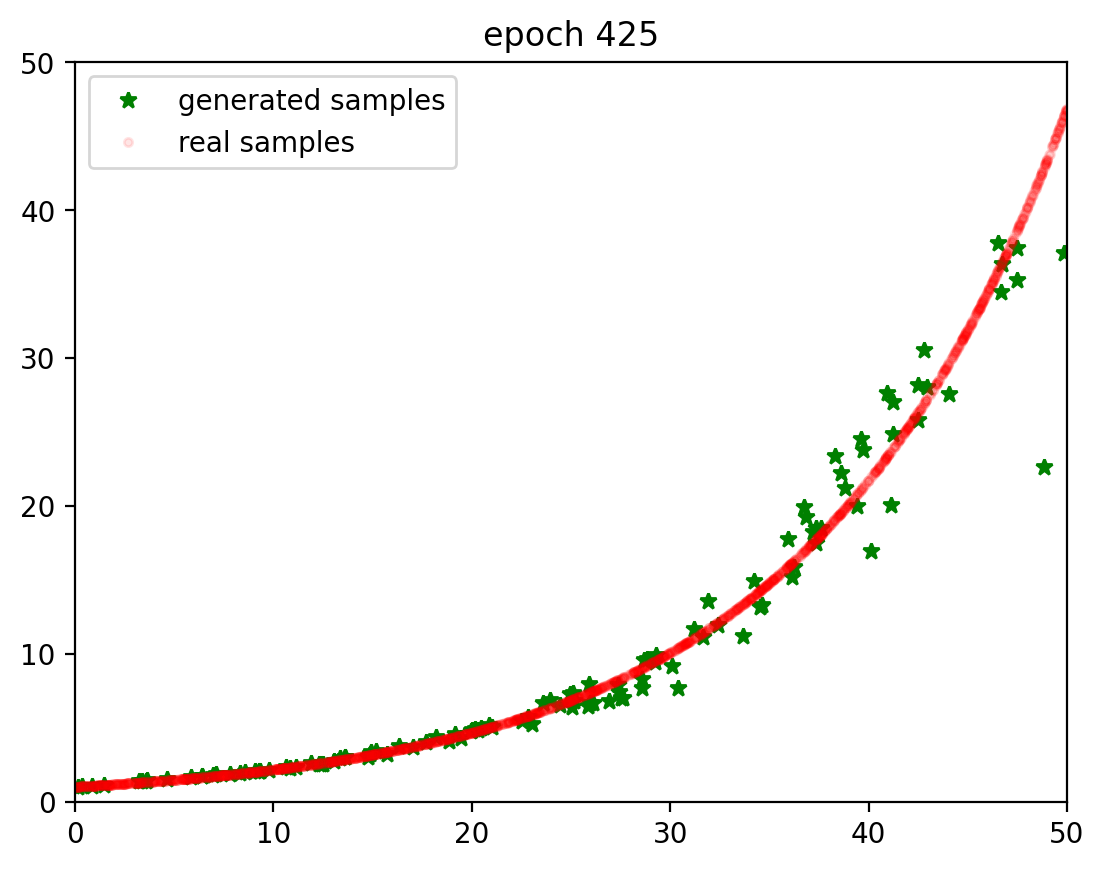

at epoch 450, G loss: 0.7476010004679362, D loss 1.4783639272054037


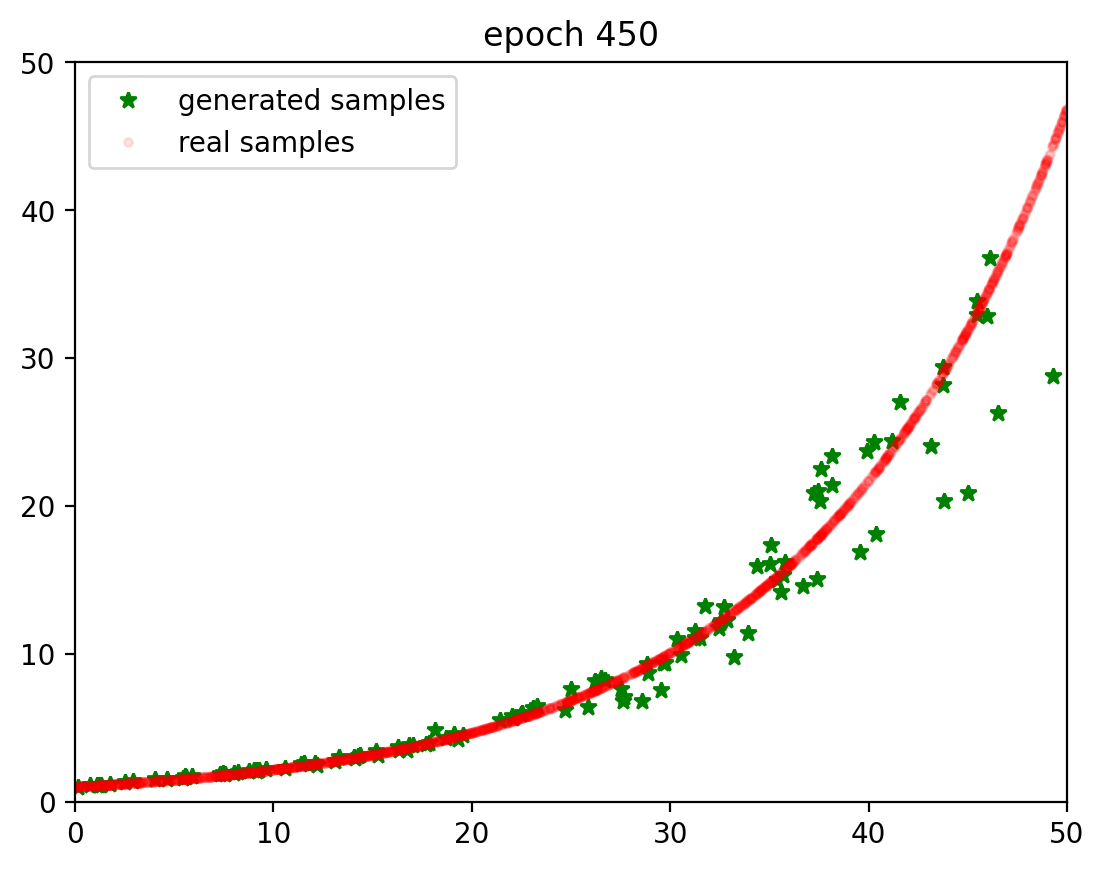

at epoch 475, G loss: 0.7522314071655274, D loss 1.4798683166503905


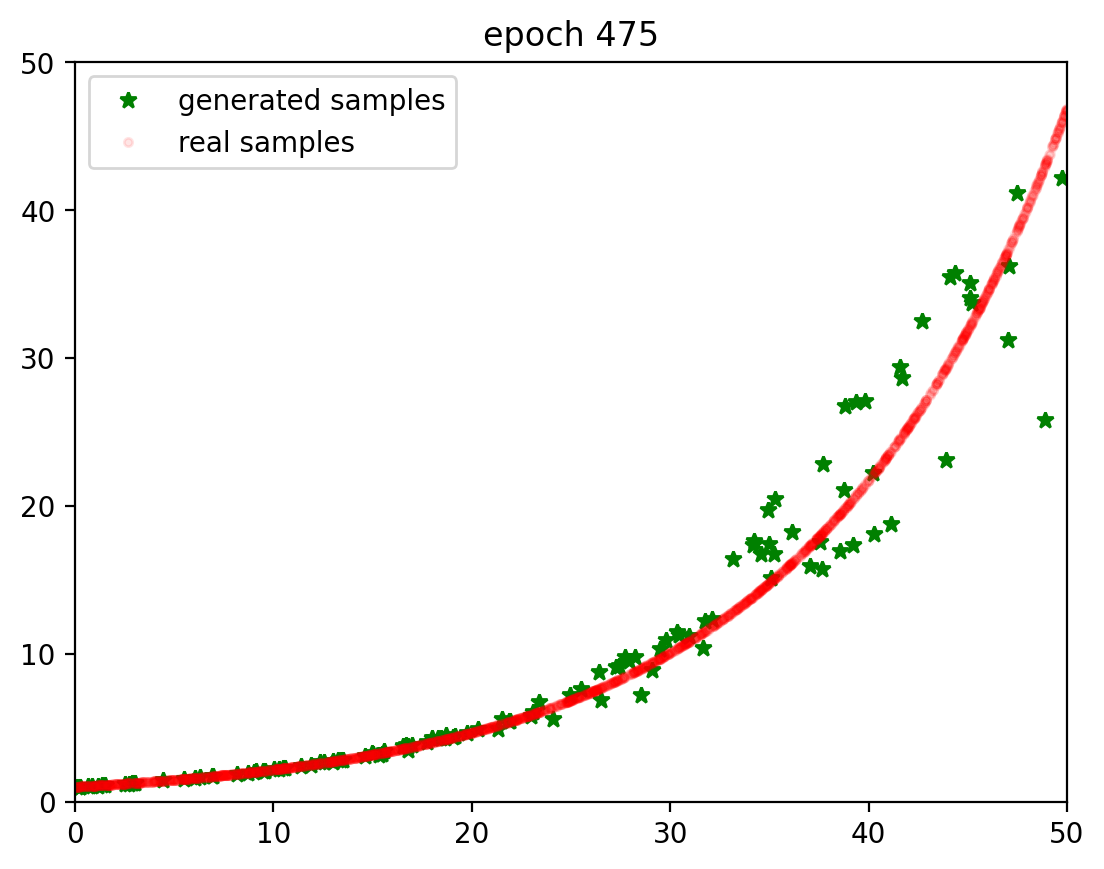

at epoch 500, G loss: 0.7601505279541015, D loss 1.477147674560547


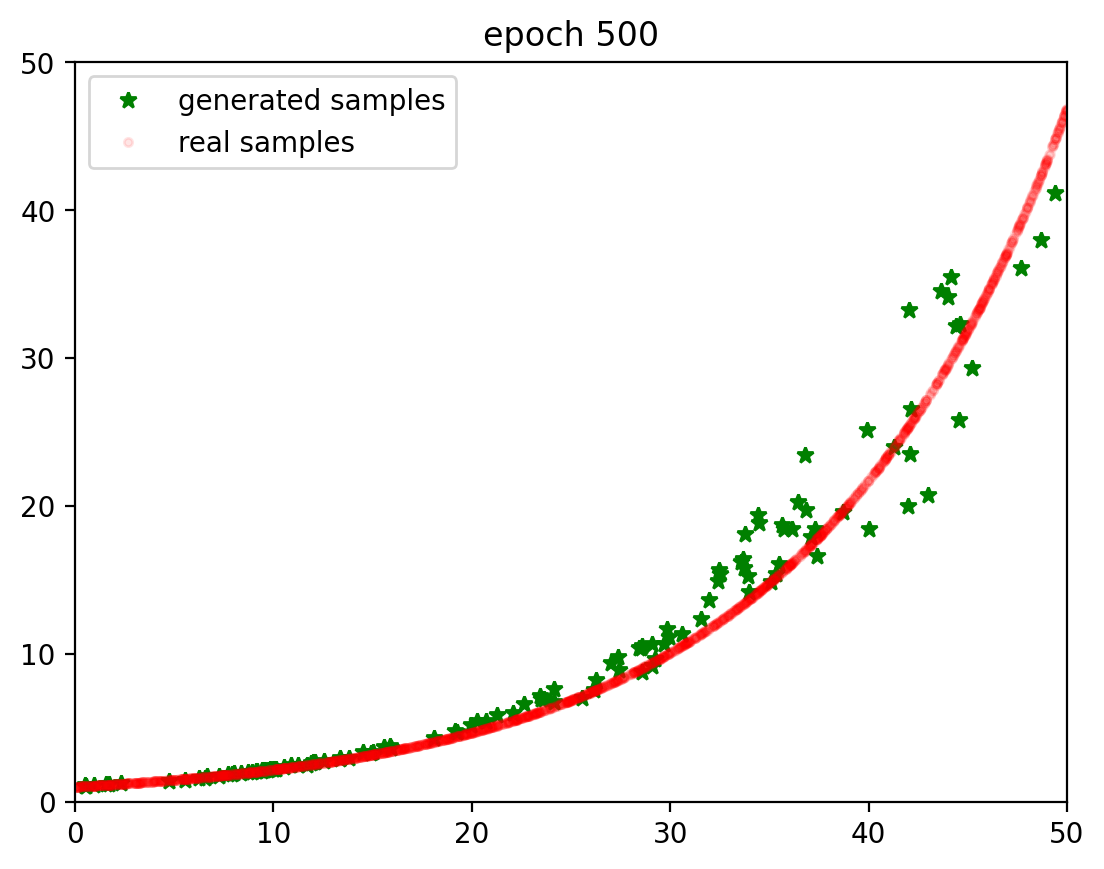

at epoch 525, G loss: 0.7492820739746093, D loss 1.4781856536865234


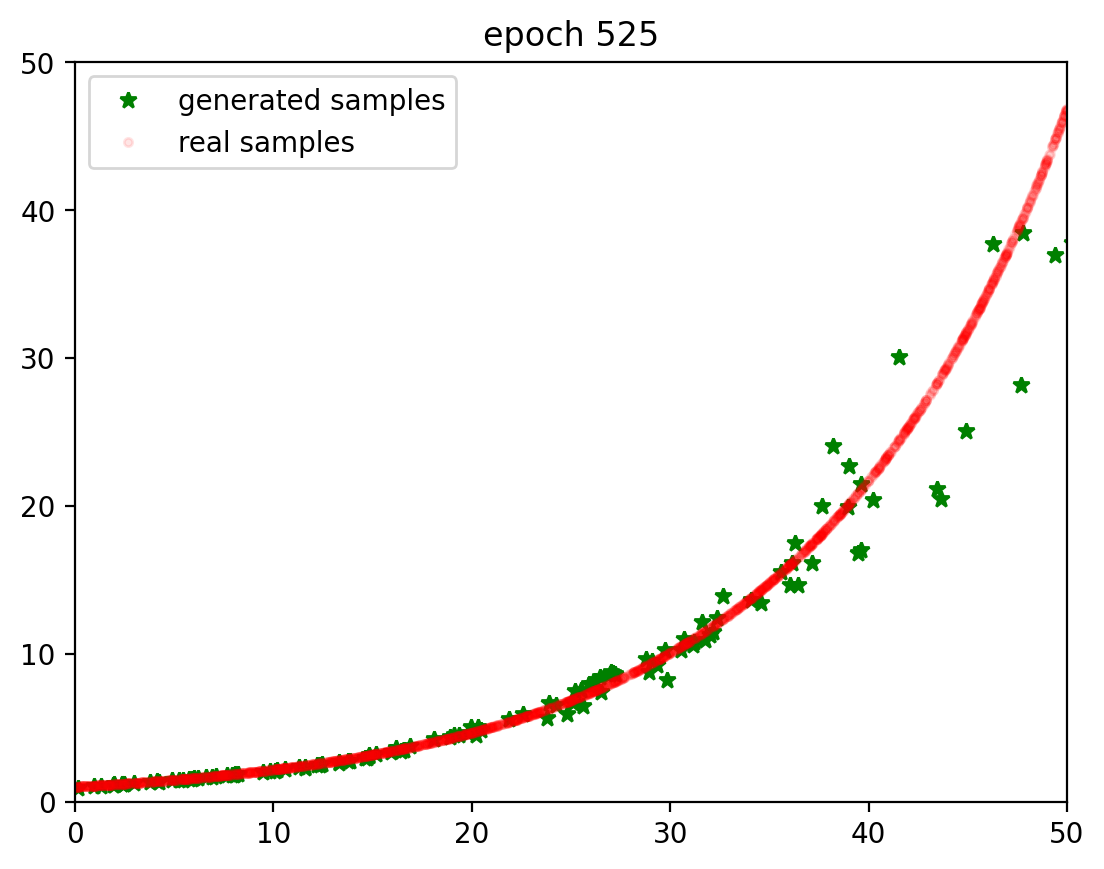

at epoch 550, G loss: 0.7487083435058594, D loss 1.4790849049886068


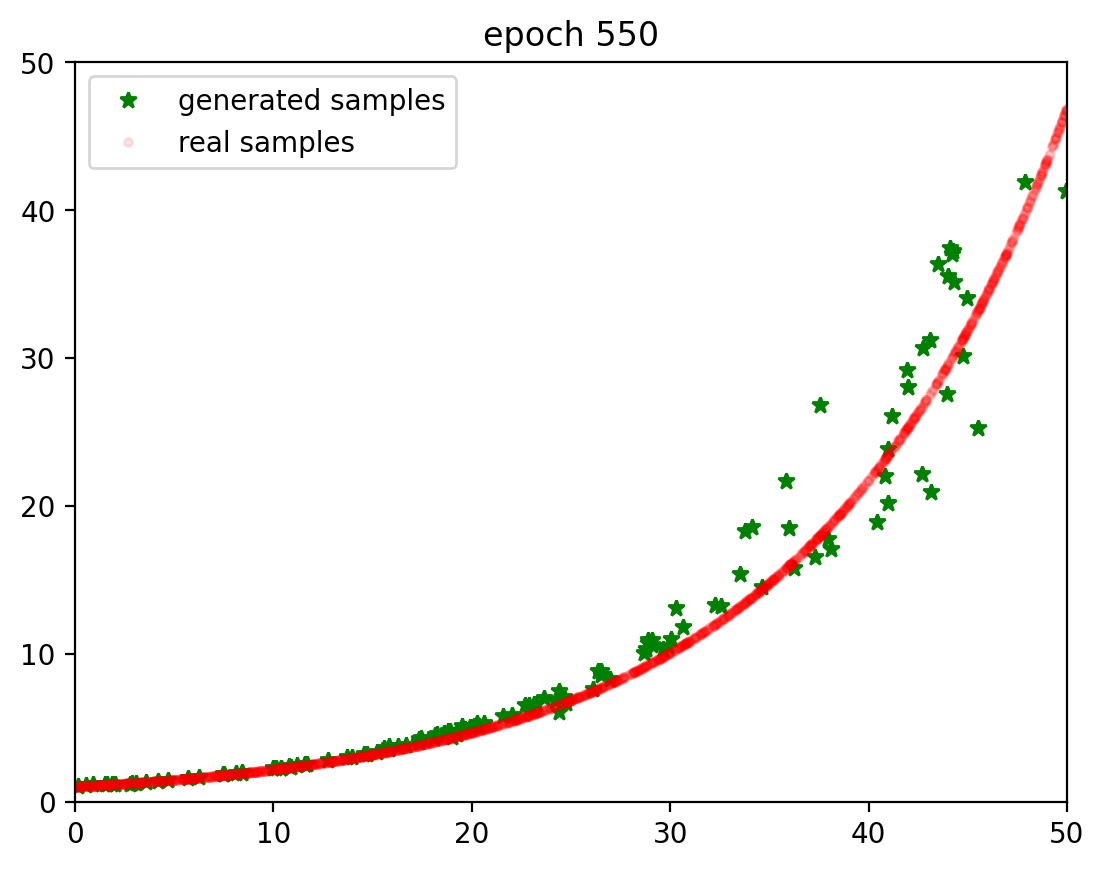

at epoch 575, G loss: 0.757017453511556, D loss 1.4750933329264322


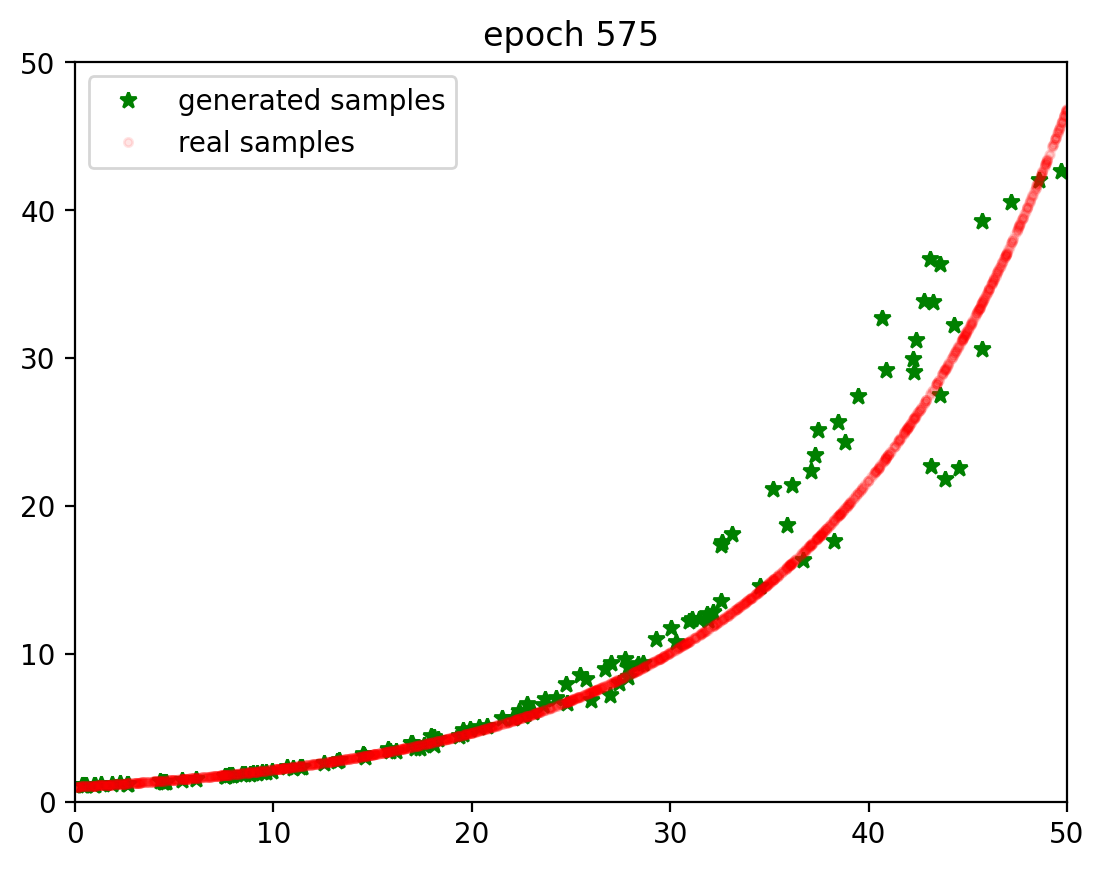

at epoch 600, G loss: 0.7471796671549479, D loss 1.479179890950521


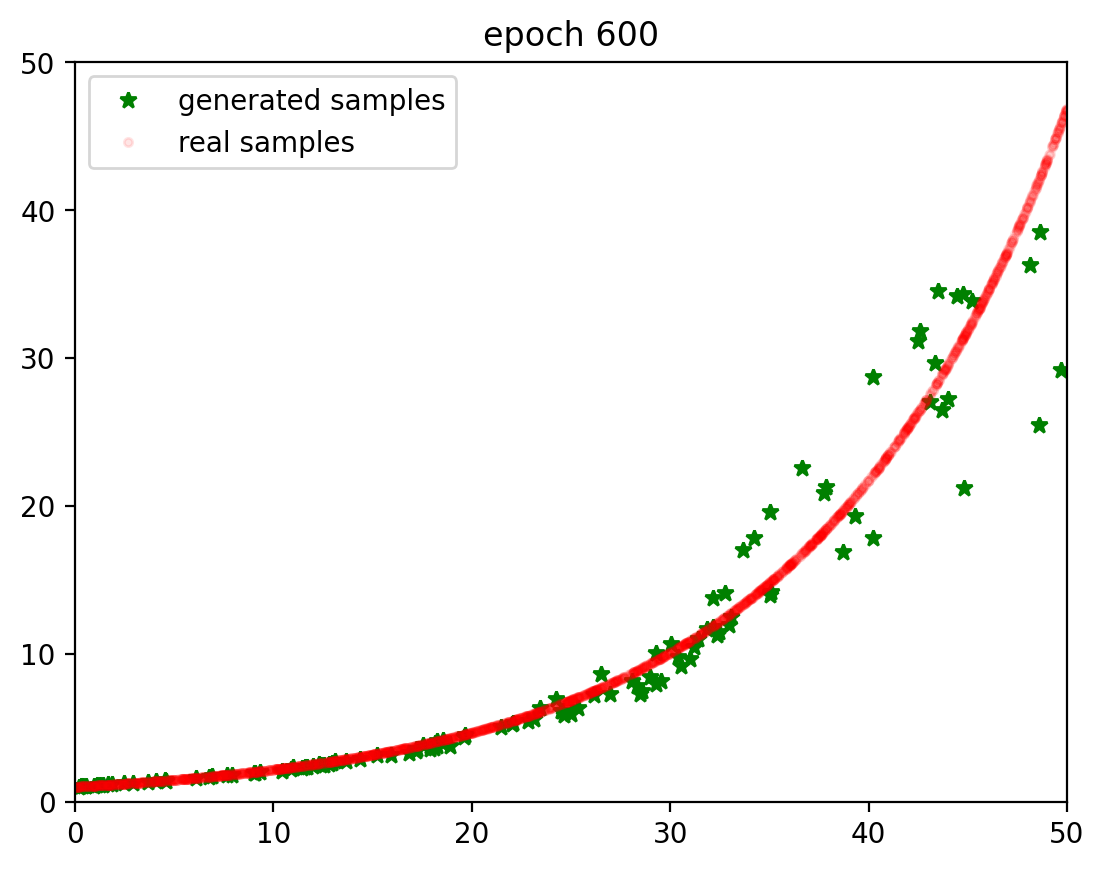

at epoch 625, G loss: 0.7595348358154297, D loss 1.4766680399576824


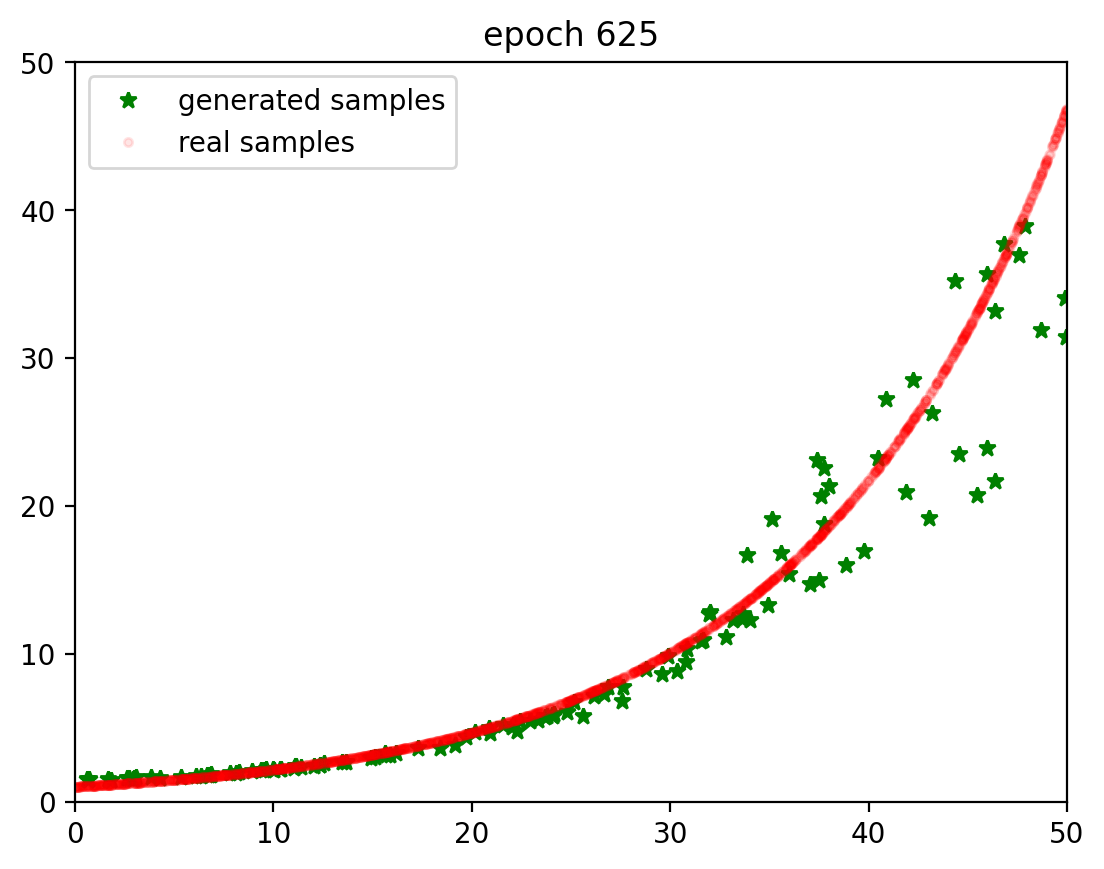

at epoch 650, G loss: 0.7470485051472981, D loss 1.478311538696289


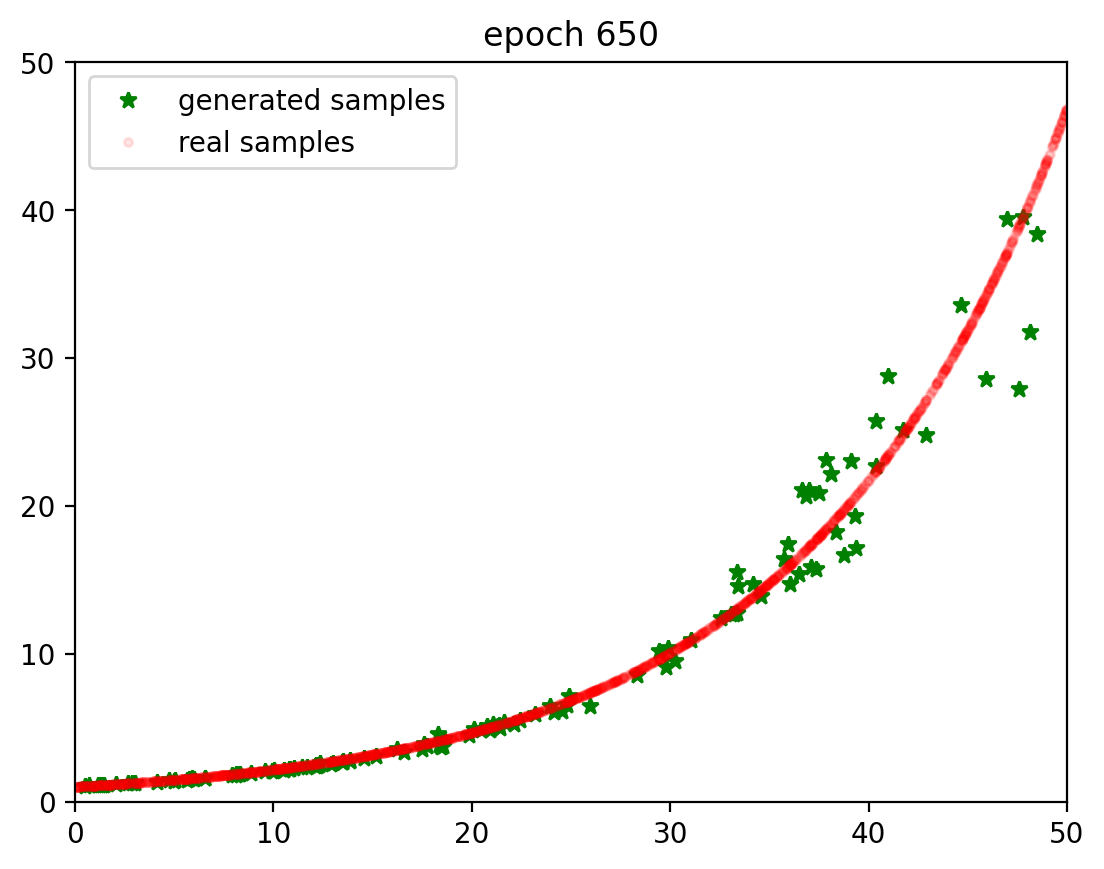

at epoch 675, G loss: 0.7498664855957031, D loss 1.477640151977539


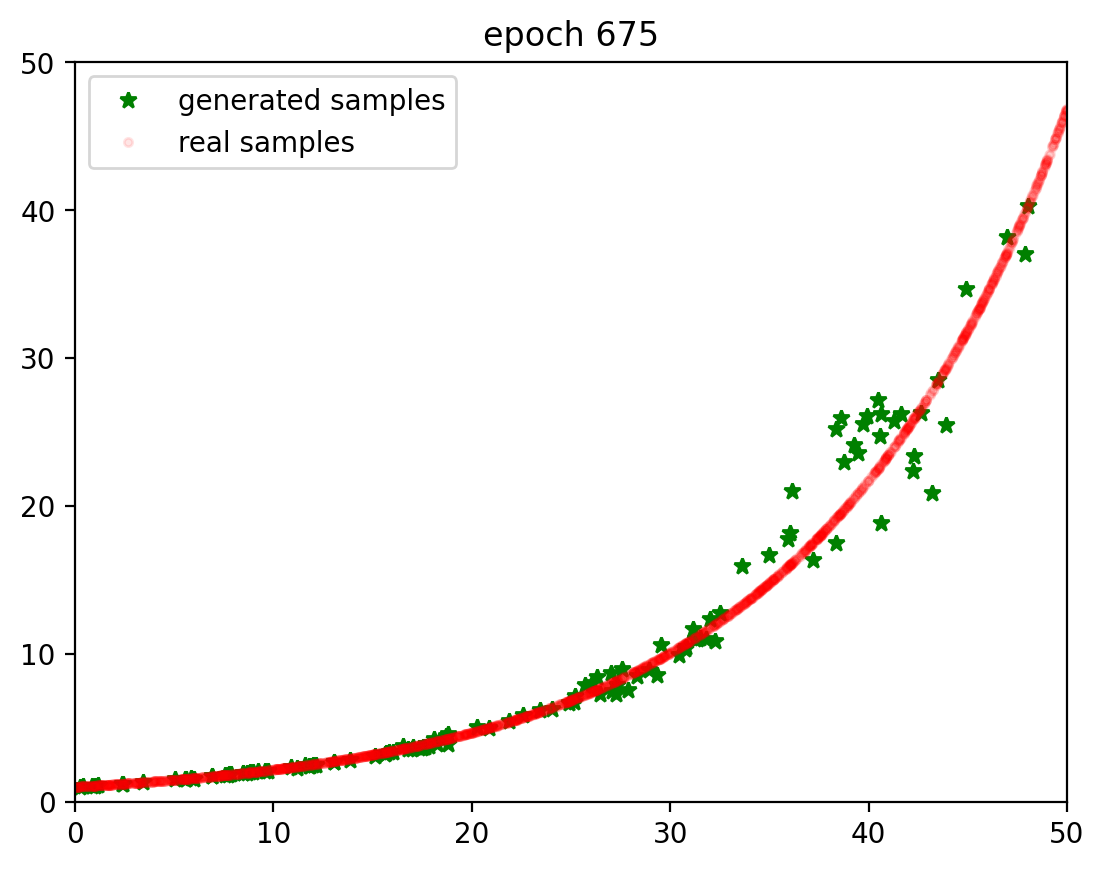

at epoch 700, G loss: 0.7569789886474609, D loss 1.4778258005777996


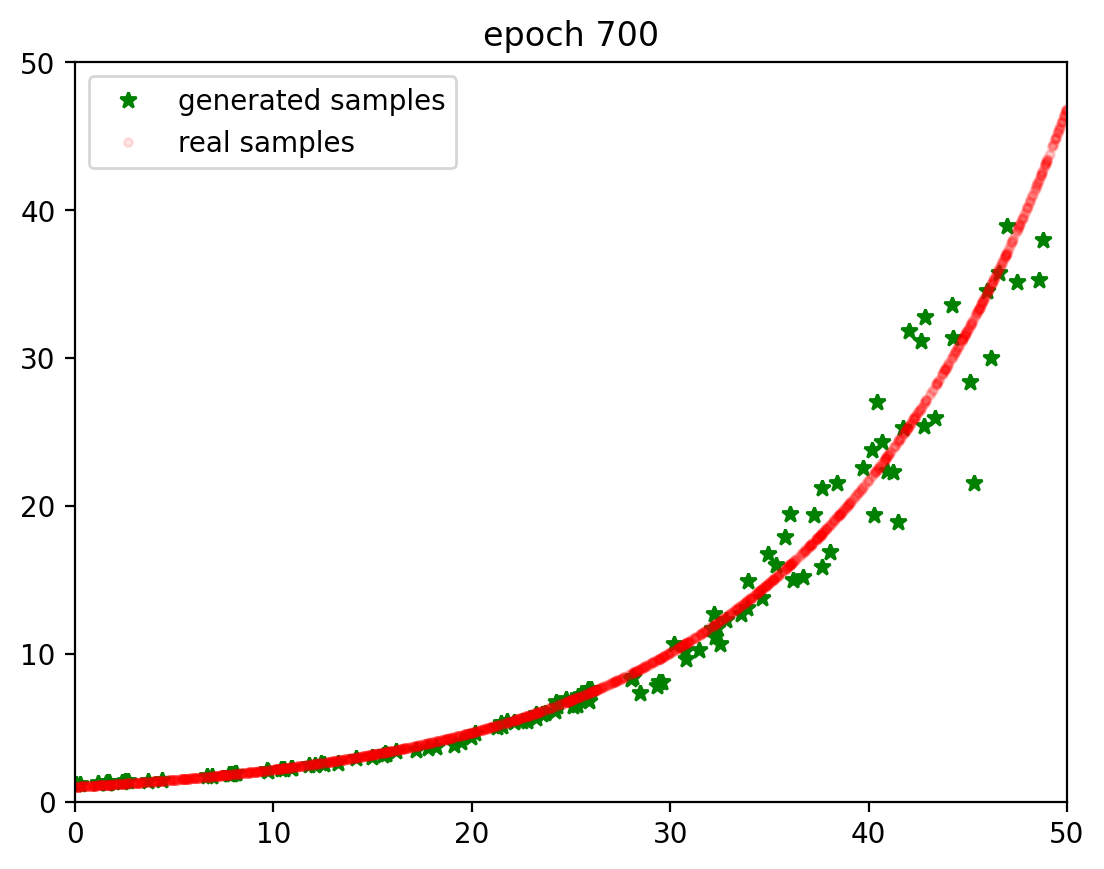

at epoch 725, G loss: 0.7467532475789388, D loss 1.4801458994547525


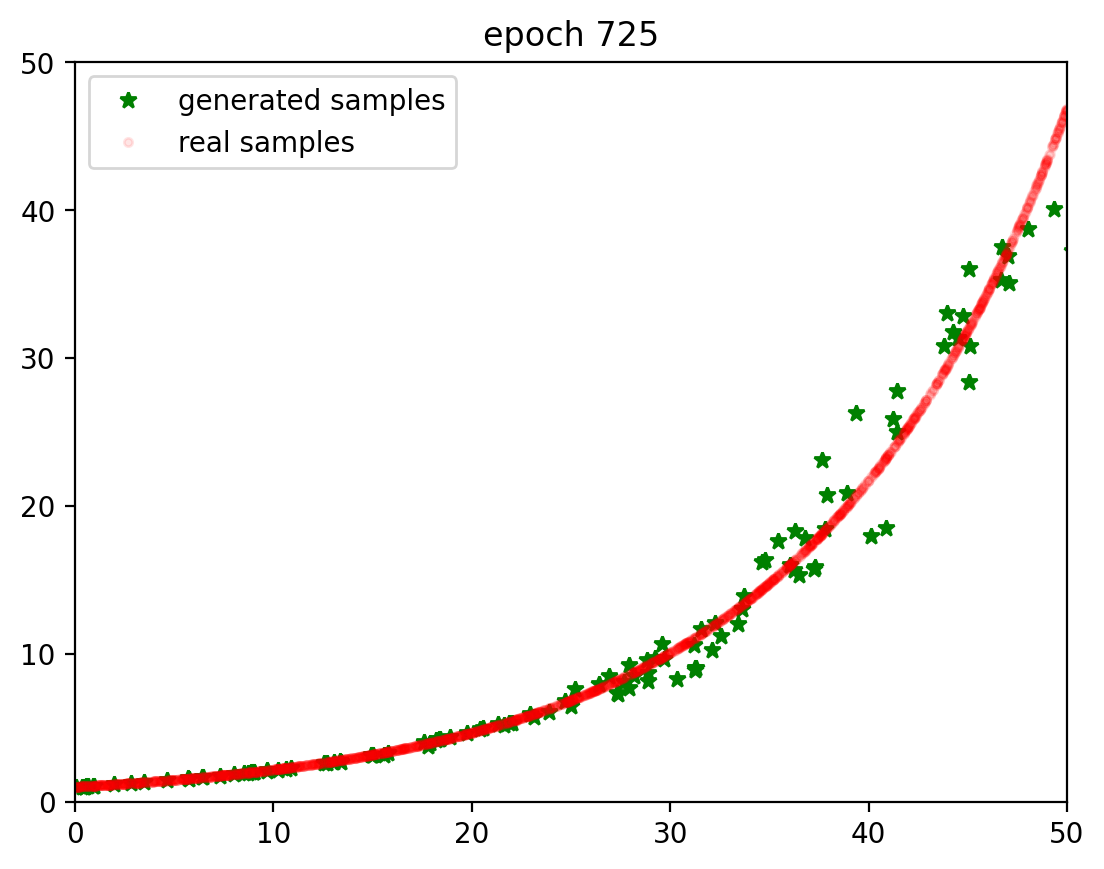

at epoch 750, G loss: 0.7637744267781575, D loss 1.4730492909749349


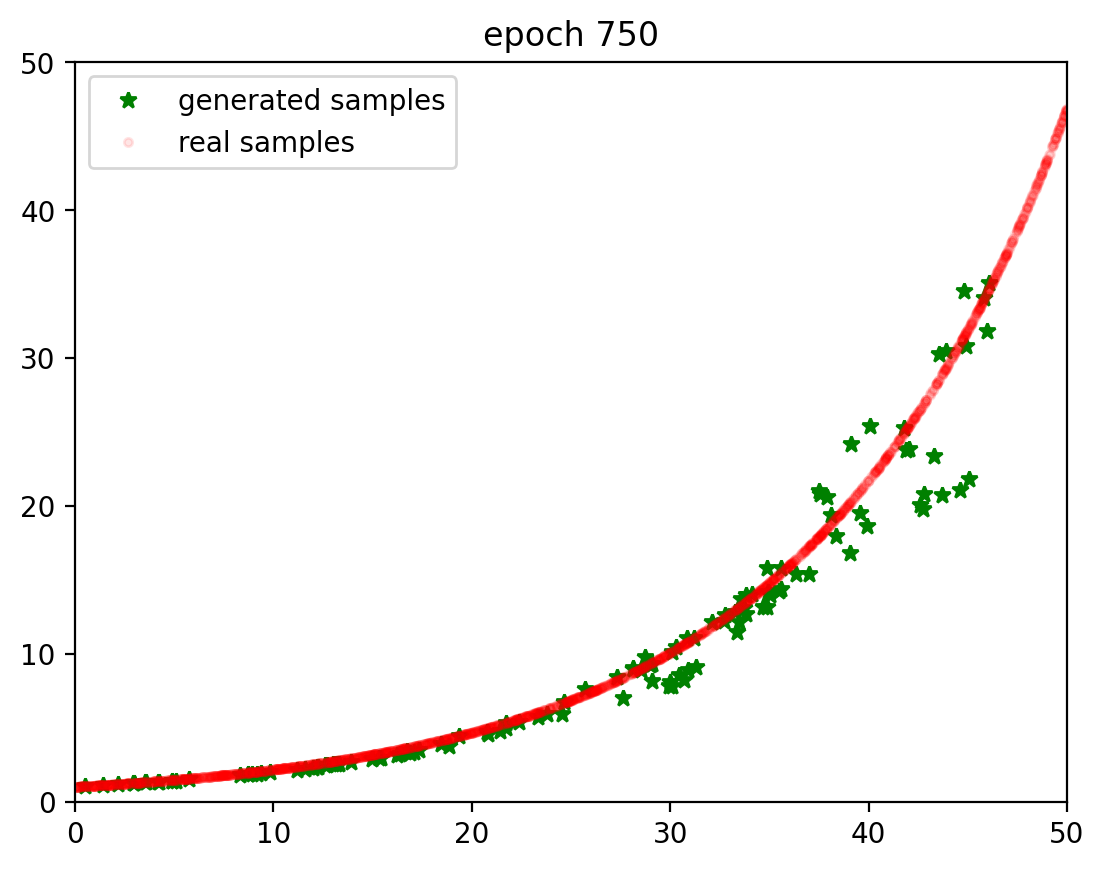

at epoch 775, G loss: 0.7541283925374349, D loss 1.476444625854492


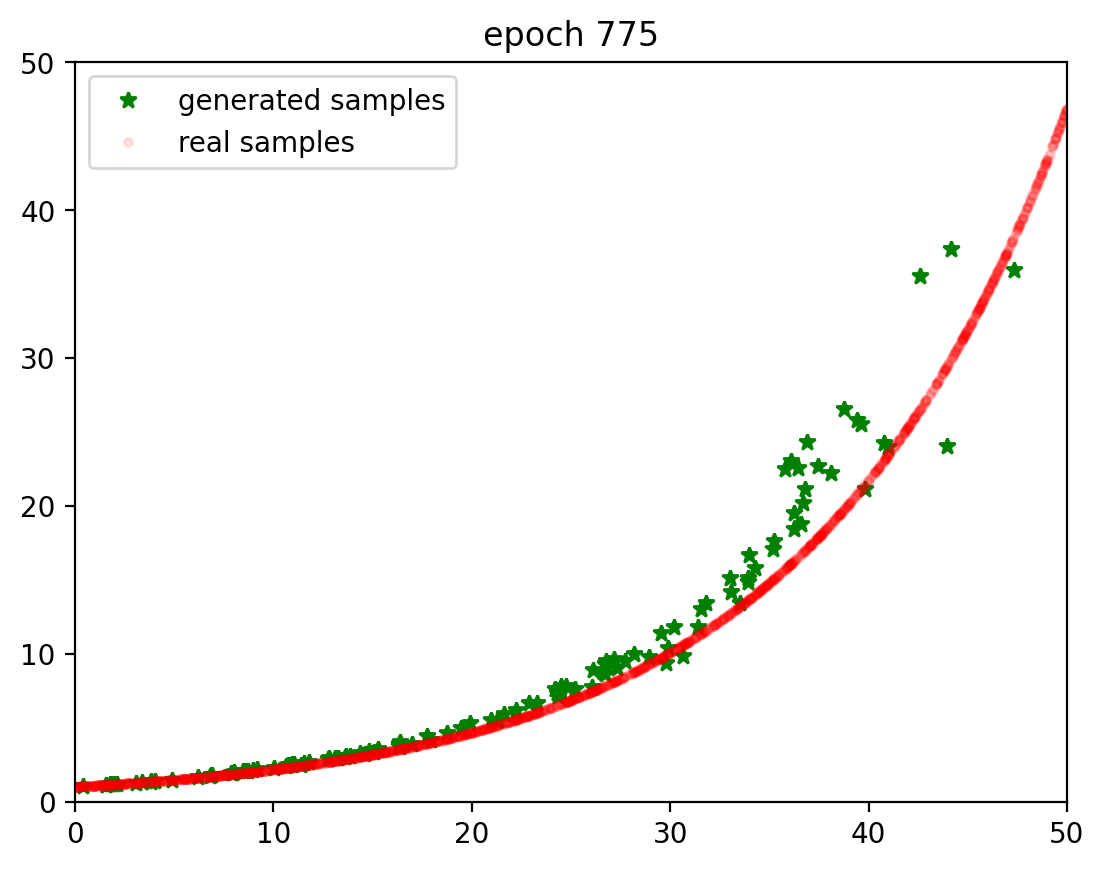

at epoch 800, G loss: 0.7469056447347006, D loss 1.4797950744628907


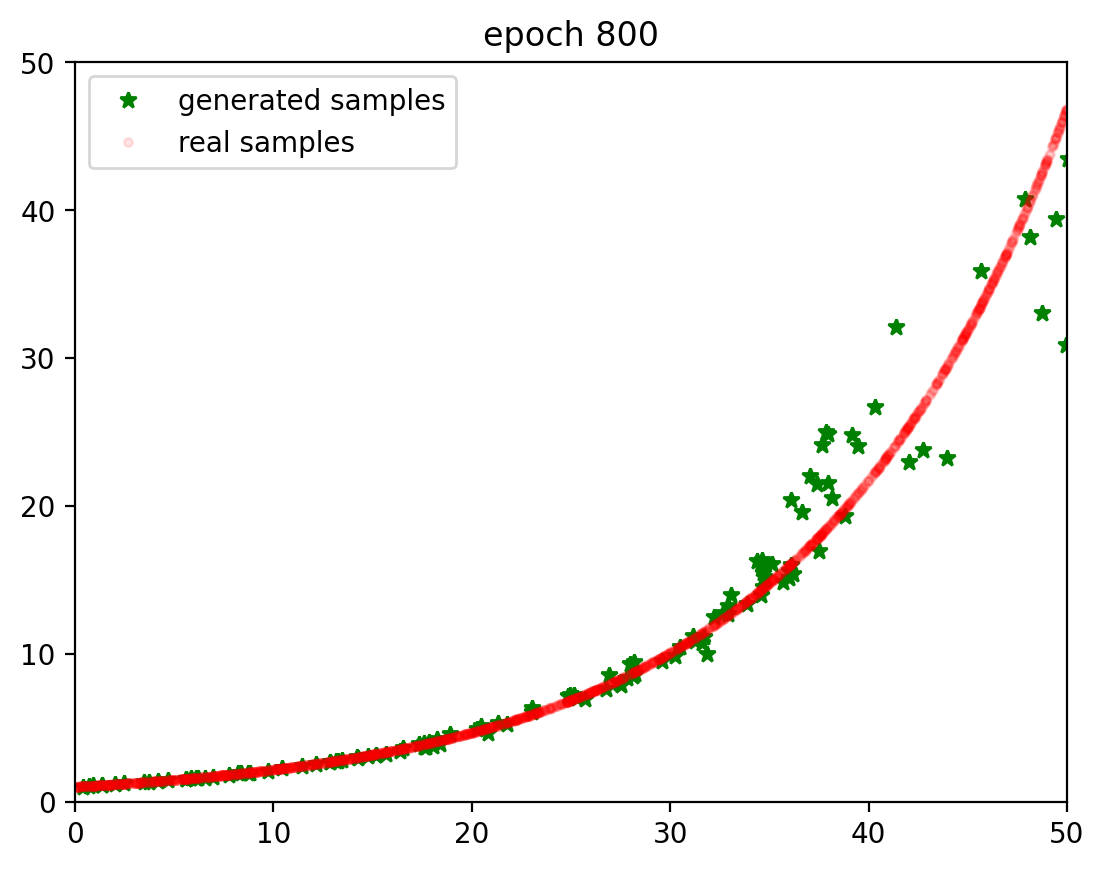

at epoch 825, G loss: 0.7475200653076172, D loss 1.477884038289388


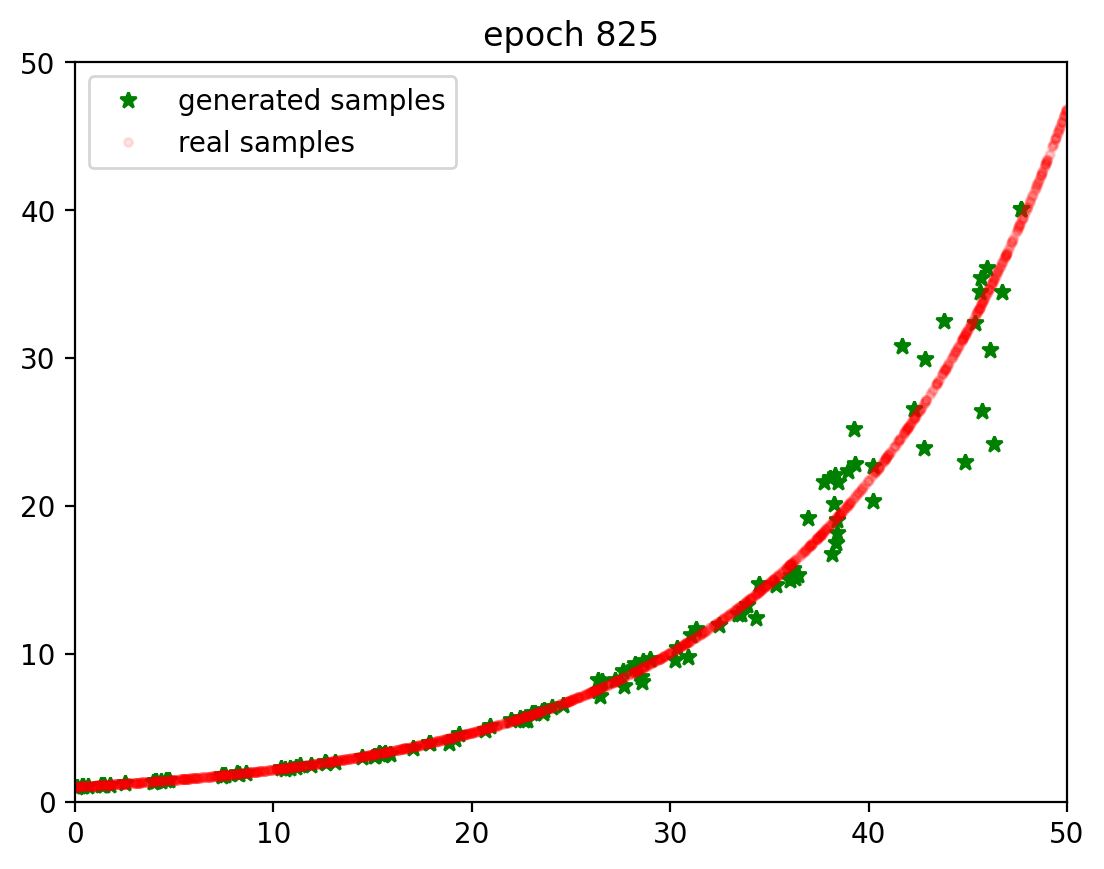

at epoch 850, G loss: 0.7506168365478516, D loss 1.4774818420410156


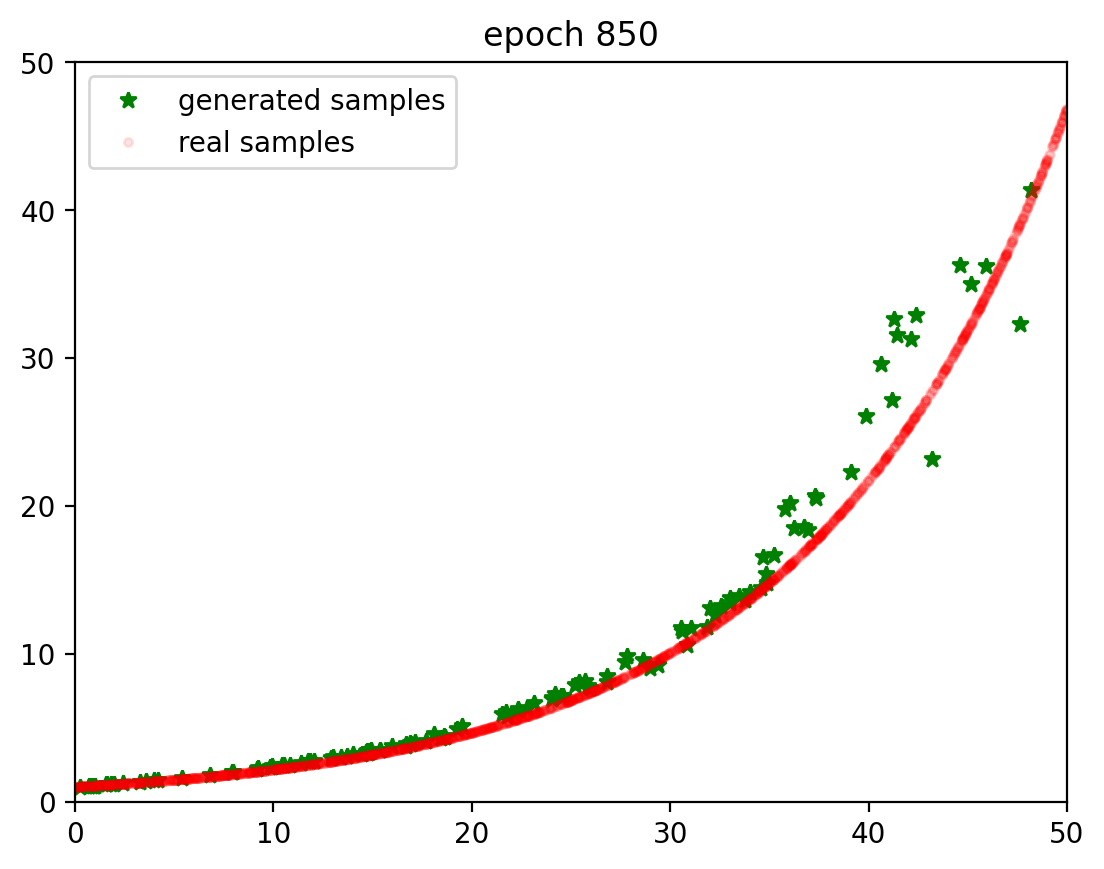

at epoch 875, G loss: 0.7496389389038086, D loss 1.4760167439778646


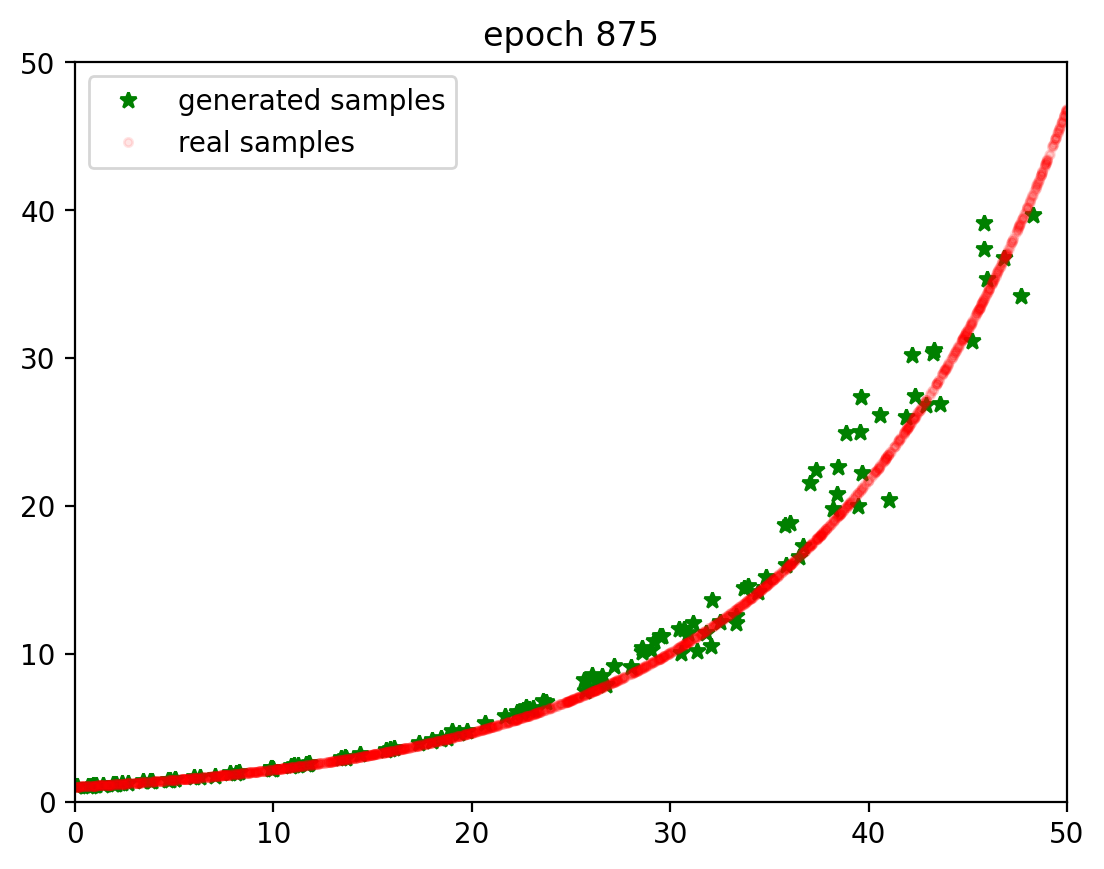

at epoch 900, G loss: 0.7486567815144857, D loss 1.4758323669433593


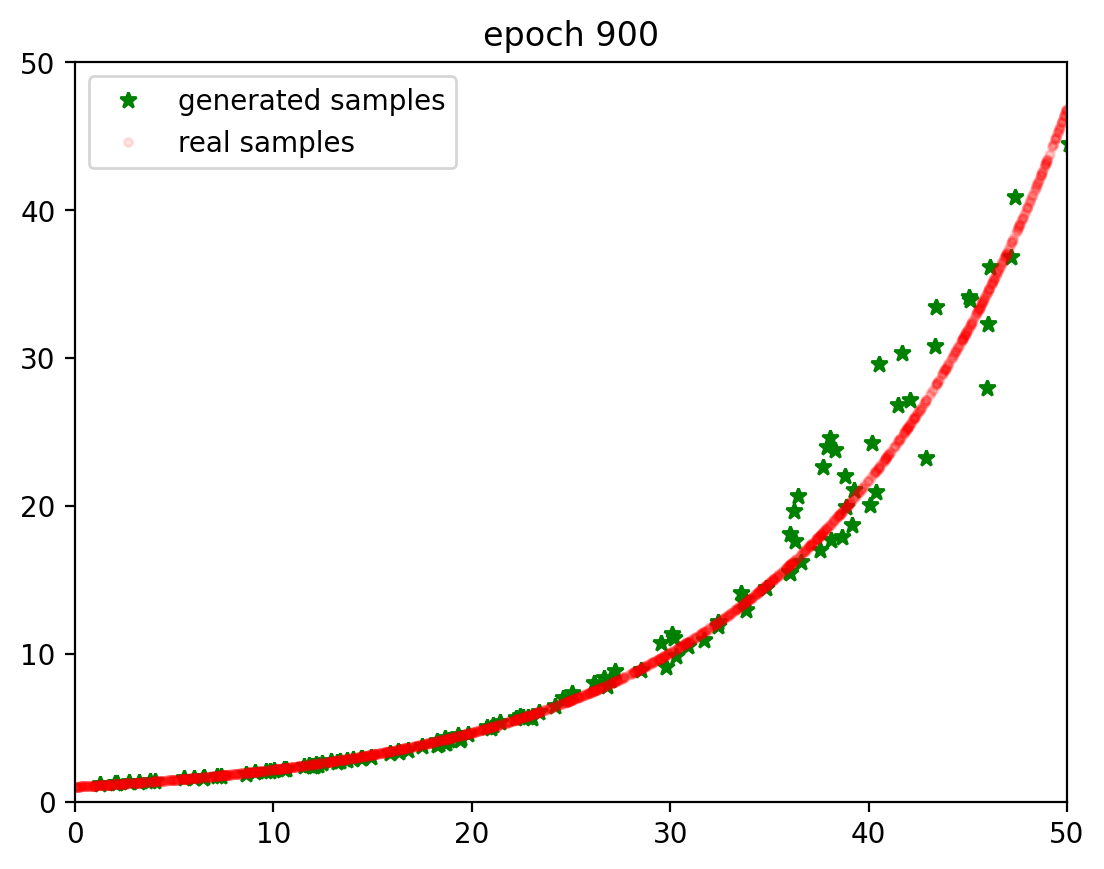

at epoch 925, G loss: 0.7546770731608073, D loss 1.476981480916341


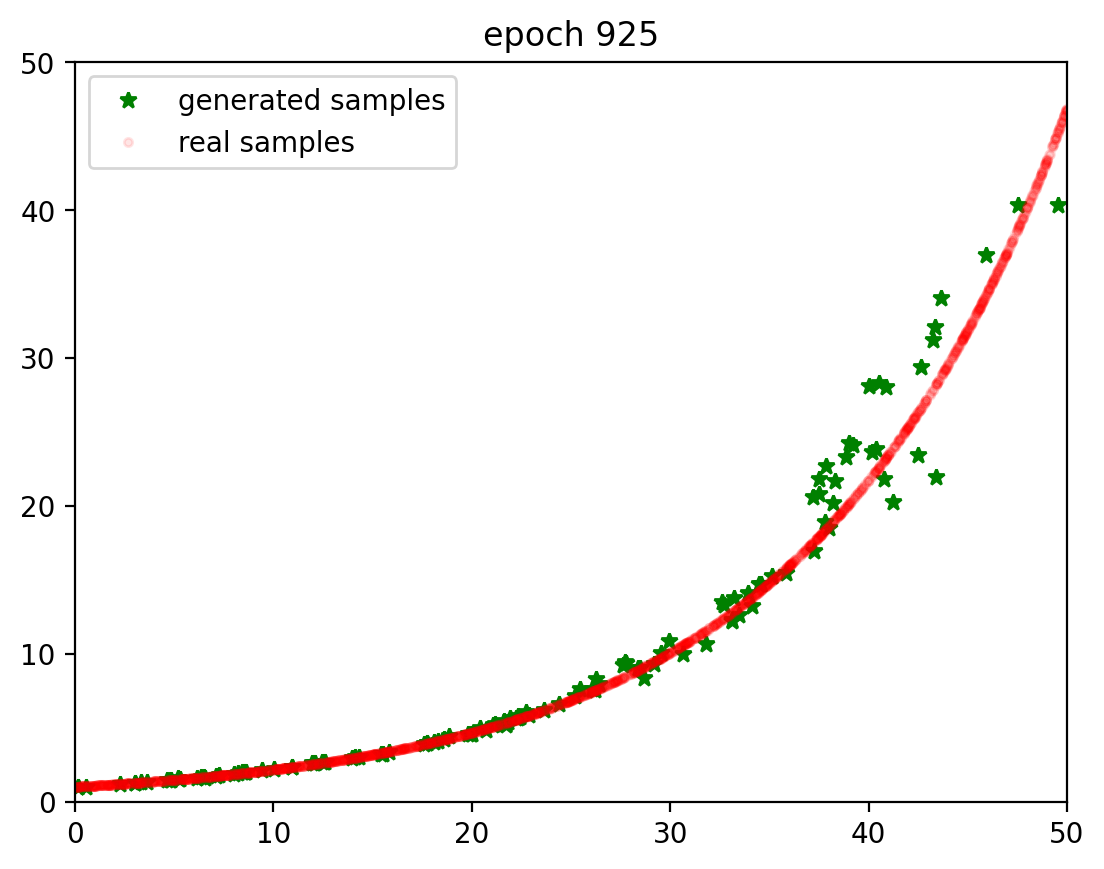

at epoch 950, G loss: 0.7553994496663411, D loss 1.4767682393391928


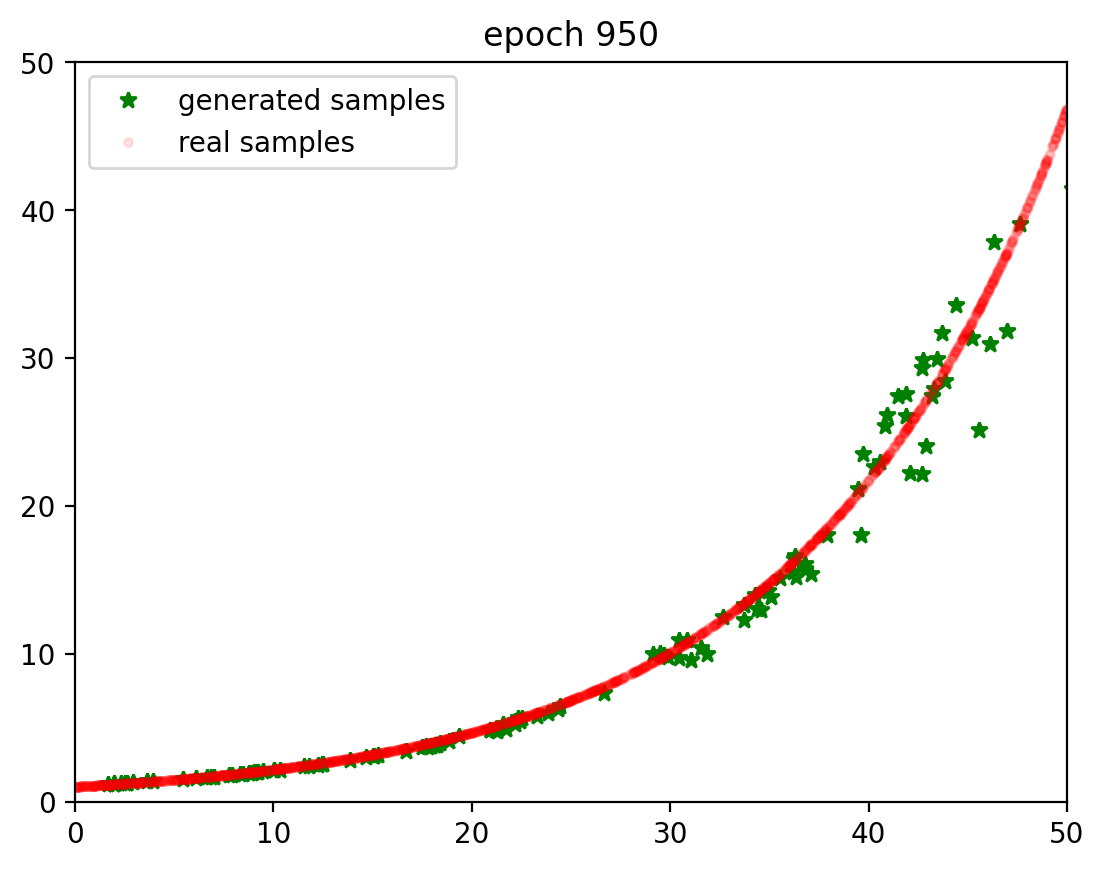

at epoch 975, G loss: 0.7477083206176758, D loss 1.471514892578125


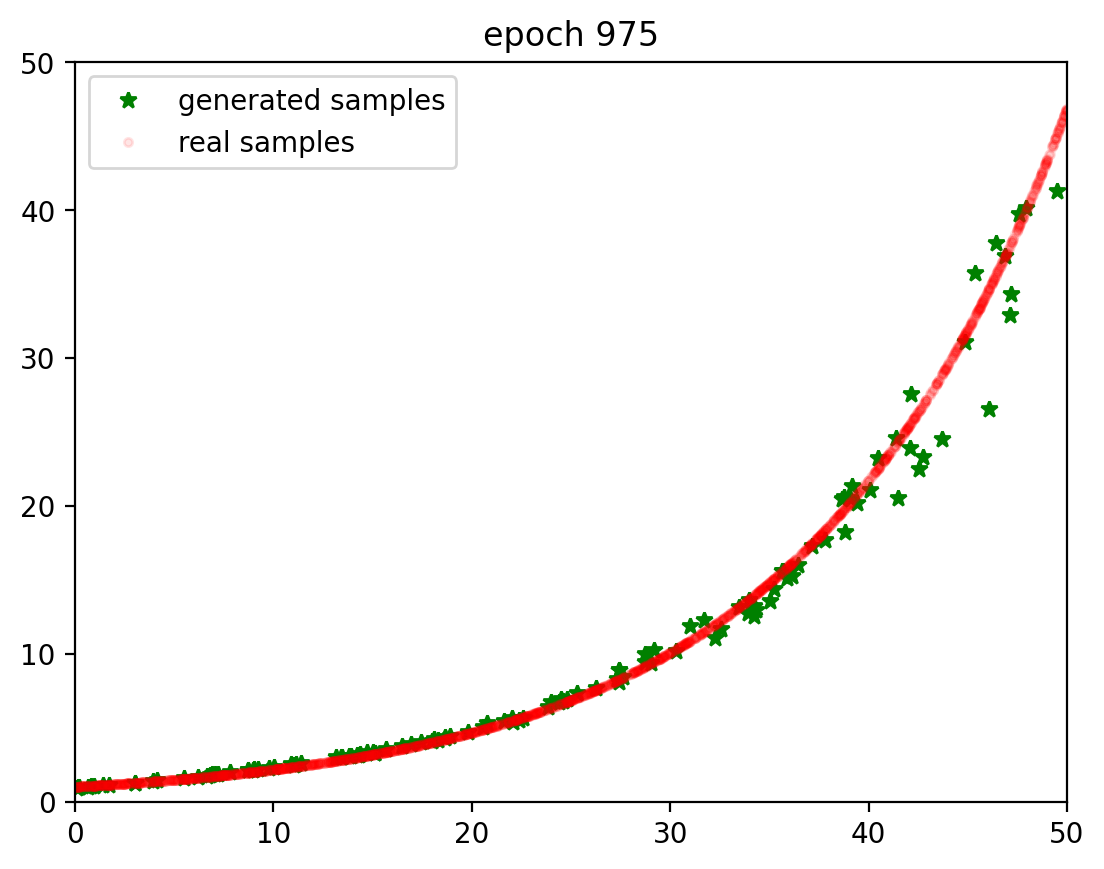

at epoch 1000, G loss: 0.7567280451456706, D loss 1.4729148864746093


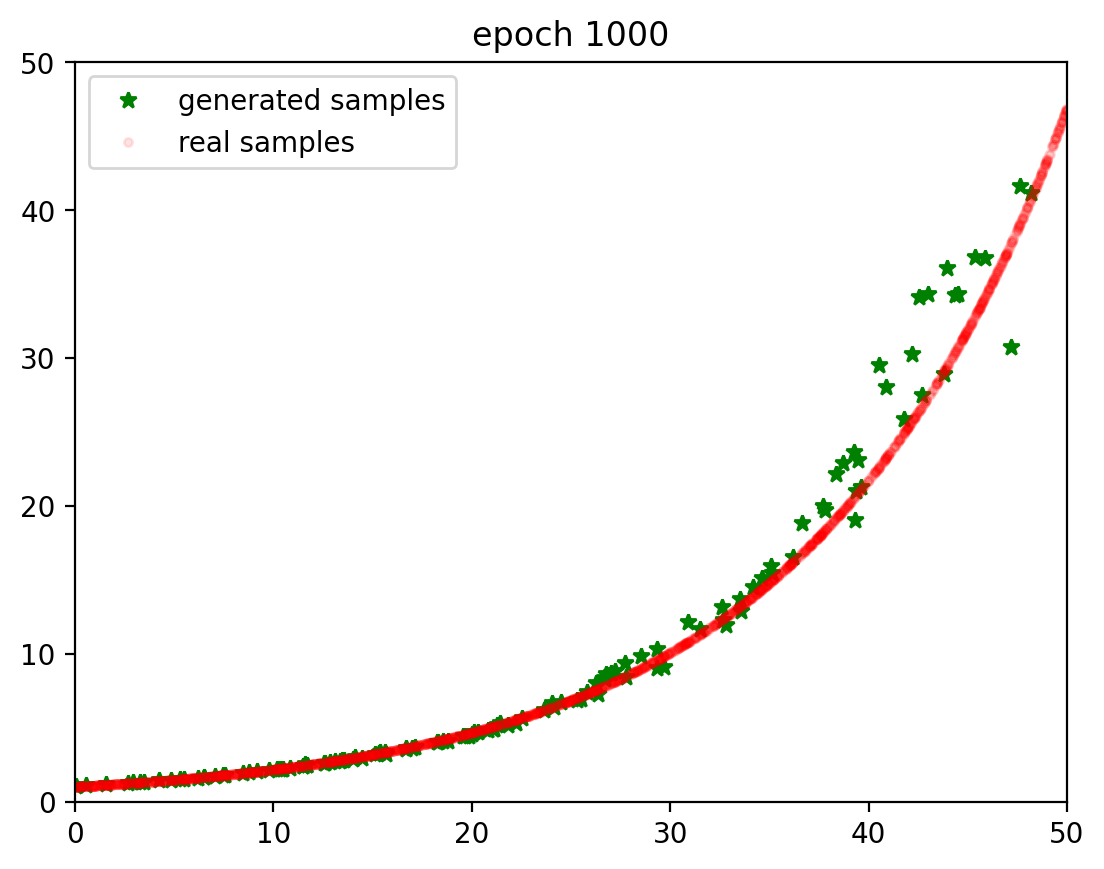

at epoch 1025, G loss: 0.7656516393025716, D loss 1.4699913024902345


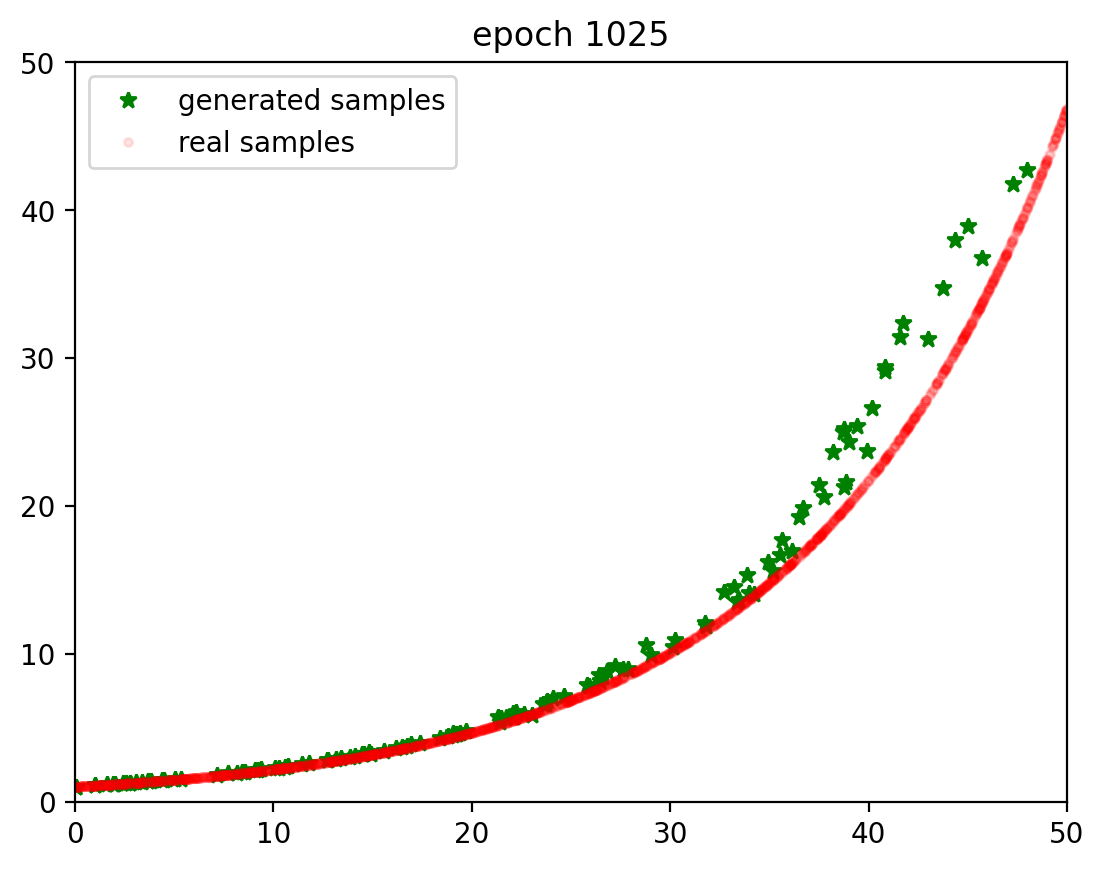

In [17]:
for epoch in range(10000):    #A
    gloss=0
    dloss=0
    for n, real_samples in enumerate(train_loader):    #B
        loss_D=train_D_on_real(real_samples)
        dloss+=loss_D
        loss_D=train_D_on_fake()
        dloss+=loss_D
        loss_G,fake_samples=train_G()
        gloss+=loss_G
    test_epoch(epoch,gloss,dloss,n,fake_samples)    #C
    gdif=performance(fake_samples).item()
    if stopper.stop(gdif)==True:    #D
        break

In [18]:
import os
os.makedirs("files", exist_ok=True)
scripted = torch.jit.script(G) 
scripted.save('files/exponential.pt') 

In [19]:
new_G=torch.jit.load('files/exponential.pt',
                     map_location=device)
new_G.eval()

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(original_name=Linear)
  (1): RecursiveScriptModule(original_name=ReLU)
  (2): RecursiveScriptModule(original_name=Linear)
  (3): RecursiveScriptModule(original_name=ReLU)
  (4): RecursiveScriptModule(original_name=Linear)
)

In [20]:
noise=torch.randn((batch_size,2)).to(device)
new_data=new_G(noise) 

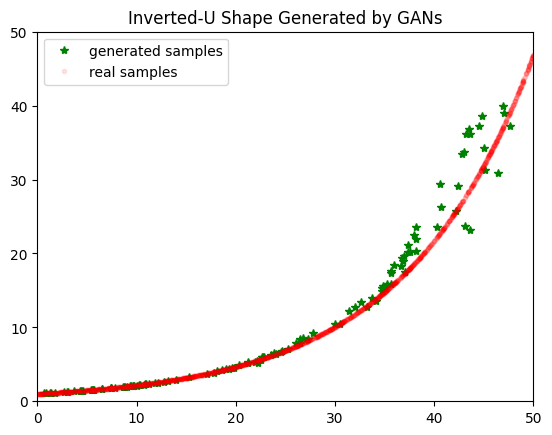

In [21]:
fig=plt.figure(dpi=100)
plt.plot(new_data.detach().cpu().numpy()[:,0],
  new_data.detach().cpu().numpy()[:,1],"*",c="g",
        label="generated samples")    #A
plt.plot(train_data[:,0],train_data[:,1],".",c="r",
         alpha=0.1,label="real samples")    #B
plt.title("Inverted-U Shape Generated by GANs")
plt.xlim(0,50)
plt.ylim(0,50)
plt.legend()
plt.show()